<a href="https://colab.research.google.com/github/DominikHommer/DocDig/blob/main/MachineLearningProjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vogelzugdaten digitalisieren

Proof of concept (POC) ob es möglich ist gescannte Vogelzugdaten anhand automatischer Inhaltserkennung zu digitalisieren.

Dieser POC wurde nur anhand von PDF's aus dem Jahr 1972 erstellt, weil sich PDFs doch stark unterscheiden können und erstmal ein Durchbruch geschaffen werden sollte.

*Von:
Dominik Hommer, Benedikt Veith, Florian Maag, Benedikt Walter*

Colab Link: https://colab.research.google.com/drive/1yDCJs89OR-UOvled6wOIJkOPycyuFXbO#scrollTo=hjDemaT8ZUun

Weitere Links:
- https://colab.research.google.com/drive/1R5GJCsJZb9o5lHMT1PPeurIM-EOQy-56
- https://colab.research.google.com/drive/1mkDv2HCYc5tS2_i_gstOJJA341QfbOYJ#scrollTo=qvETaIo_c0pj
- https://colab.research.google.com/drive/1NzcvNEKGLrFVyu6cxqIa_yheNT1g4oDO
- https://colab.research.google.com/drive/1UfVeYZQBs0PqohQPBgfgpTLoz5aC9LW8

## README
- This notebook represents the "final" stage of our project. Please do not edit without group consent before




# Das Projekt

Installation von notwendigen python libaries

In [ ]:
# Installs
!pip install pdf2image
!pip install scipy
!pip install opencv-python
!pip install Pillow
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (389 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


HTR-Pipeline & WordDetector Github Repo

In [ ]:
%cd

# Install Git
!apt-get install -y git

# Clone the repository
!git clone https://github.com/githubharald/WordDetector.git
!git clone https://github.com/githubharald/HTRPipeline.git

%cd WordDetector
!pip install .

%cd

%cd HTRPipeline
!pip install .

%cd

/root
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Cloning into 'WordDetector'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 91 (delta 17), reused 18 (delta 15), pack-reused 66
Receiving objects: 100% (91/91), 2.33 MiB | 25.89 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Cloning into 'HTRPipeline'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 51 (delta 12), reused 45 (delta 11), pack-reused 5
Receiving objects: 100% (51/51), 3.49 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/root/WordDetector
Processing /root/WordDetector
  Preparing metadata (setup.py) ... done
  Created wheel for wor

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%mkdir '/usr/local/lib/python3.10/dist-packages/htr_pipeline/models/'
%cp "/content/drive/MyDrive/Scans/notebooks/Daten - DH/htr_pipeline/reader.onnx" /usr/local/lib/python3.10/dist-packages/htr_pipeline/models/
%cp "/content/drive/MyDrive/Scans/notebooks/Daten - DH/htr_pipeline/reader.json" /usr/local/lib/python3.10/dist-packages/htr_pipeline/models/
%cp "/content/drive/MyDrive/Scans/notebooks/Daten - DH/htr_pipeline/detector.onnx" /usr/local/lib/python3.10/dist-packages/htr_pipeline/models/

In [ ]:
# Imports
from pdf2image import convert_from_path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt
from PIL import Image as im, ImageDraw, ImageFont
from scipy.ndimage import interpolation as inter
import cv2 as cv
from google.colab.patches import cv2_imshow
from word_detector import prepare_img, detect, sort_line, sort_multiline
from htr_pipeline import read_page, DetectorConfig, LineClusteringConfig, ReaderConfig, PrefixTree
import uuid
import json
import os
import random

from sklearn.metrics import classification_report

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Segmentierung

Die Segmentierung und die Tabellenausrichtung sind wichtige Aspekte die möglichst gut funktionieren sollten bevor wir mit dem Erkennen der Zellen beginnen. Je genauer und besser die Tabellenausrichtung und Segmentierung funktionieren, desto weniger Arbeit gibt es für die Erkennung oder eventuelle Zwischenschritte entstehen erst gar nicht.

Zuerst wird das Bild so bearbeitet das Bildbearbeitungsfunktionen gut auf dem Bild funktionieren. Dies wird mittels Farbkonvertierung ermöglicht, das heißt das Bild wird in Graustufen konvertiert, um es anschließend in ein Schwarzweiß Bild umzuwandeln.

Um das Bild mit der Tabelle gerade zu stellen wird die HoughLinesP von OpenCV verwendet, welche prägnante Linien im Bild erkennt. Diese Linien werden dann weiter bearbeitet. Fast horizontale Linien werden komplett aussortiert, da wir uns nur für den Winkel zur vertikalen Interessieren. Außerdem werden ähnliche Linien zusammen geführt, sodass wir im besten Fall das fast vertikale Tabellenlayout erkennen.

Bei der Segmentierung werden ebenfalls ähnliche Methoden aus der OpenCV Liberary verwendet. Das Verfahren ist dabei das gleiche wie zur Ausrichtung des Bildes. Wir bereiten die Tabelle vor (Schwarzweiß Bild, Inhalt blur), erkennen vertikale Linen, filtern diese nach relevanten und schneiden dementsprechend Spalten aus. Bei den Spalten machen wir die selben Schritte nur in horizontaler Richtung um Zellen zu segmentieren.

Als letzter Schritt werden die Zellen nachbearbeitet (Dieser Schritt entstand erst **nachdem** wir bereits das CNN trainiert haben, ein zweiter Durchlauf mit dem CNN war leider zeitlich nicht mehr möglich. Siehe unten). Bei der Nachbearbeitung werden die horizontale / vertikale Ränder anhand der Pixelverteilung der Zelle konditional entfernt. Danach versuchen wir die Zelle und mögliche entstandene Schäden zu "reparieren". Dabei wird auch ein wenig Noise entfernt. Der Prozess der Nachbearbeitung ist noch WIP und kann deutlich verbessert werden.

Am Ende haben wir nun die fertigen Zellen aus der Spalte der Vogelarten (Spalte 1) und der Spalte "Aile" (Spalte 6) in einem array. Ready für die Erkennung via CNN :)



In [ ]:
class SegmentationClient:
  def __init__(self) -> None:
     pass

  def rotateImg(self, img, verticalL):
    ##
    # Rotate skewed image based on vertical lines
    ##
    verticalL.sort(key=lambda x: x[0][0])
    filteredVerticalLines = [verticalL[0]]

    for i in range(1, len(verticalL)):
        current_line = verticalL[i]
        prev_line = verticalL[i-1]
        distance = current_line[0][0] - prev_line[0][0]

        if distance > 120:
            filteredVerticalLines.append(current_line)

    angles_to_horizontal = []

    for line in filteredVerticalLines:
        x1, y1, x2, y2 = line[0]

        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            angle_to_horizontal = np.degrees(np.arctan(slope))
            angles_to_horizontal.append(angle_to_horizontal)
        else :
            angles_to_horizontal.append(-90)

    filtered_angles = [90 - angle if angle > 0 else angle for angle in angles_to_horizontal]
    rotation_angle = filtered_angles[0]

    if rotation_angle < 0:
      rotation_angle = 90 + rotation_angle

    (h, w) = img.shape[:2]
    center = (0,0)
    M = cv.getRotationMatrix2D(center, rotation_angle, 1.0)

    return cv.warpAffine(img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

  def cellPostProcessing(self, cell):
      ##
      # Tries to post process the cutout cells by removing border lines and noise
      # Tries to repair the word / number if some parts of it were cutout during post processing
      ##
    blurCellWidth = np.copy(cell)
    exampleCell = np.copy(cell)

    h, w = exampleCell.shape[:2]

    # Blur horizontal to make the horizontal lines "thicker"
    blurCellWidth = cv.GaussianBlur(blurCellWidth, (21, 1), 0)
    blurCellWidth = cv.GaussianBlur(blurCellWidth, (31, 1), 0)
    blurCellWidth = cv.GaussianBlur(blurCellWidth, (41, 1), 0)

    # Removes all horizontal / vertical lines in array which are higher than defined threshold
    def cleanupLines(sumArray, cellArray, threshold, totalSize, isVertical = False):
      cleanLines = True
      while (cleanLines == True):
          maxIndex = np.argmax(sumArray)

          if isVertical:
              if ((sumArray[maxIndex] / totalSize) > threshold):
                  sumArray[maxIndex] = 0
                  for i in range(0, totalSize):
                      cellArray[i][maxIndex] = 255
              else:
                  cleanLines = False
          else:
              if ((sumArray[maxIndex] / totalSize) > threshold):
                  cellArray[maxIndex] = np.ones(totalSize) * 255
                  sumArray[maxIndex] = [0]
              else:
                  cleanLines = False

      return cellArray

    # Build histograms of horizontal / vertical black pixel distributions
    horizontal_hist = blurCellWidth.shape[1] - np.sum(blurCellWidth, axis=1, keepdims=True) / 255
    vertical_hist = exampleCell.shape[0] - np.sum(exampleCell, axis=0, keepdims=True) / 255

    exampleCell = cleanupLines(horizontal_hist, exampleCell, 0.3, w)
    exampleCell = cleanupLines(vertical_hist[0], exampleCell, 0.7, h, True)

    # Try to repair cell
    invCell = 255 - cell
    removed = 255 - np.copy(exampleCell)
    repair_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))
    dilate = cv.dilate(removed, repair_kernel, iterations=4)
    pre_result = cv.bitwise_and(dilate, invCell)

    result = cv.morphologyEx(pre_result, cv.MORPH_CLOSE, repair_kernel, iterations=2)
    final = cv.bitwise_and(result, invCell)

    final = cv.dilate(final, repair_kernel, iterations=2)
    final = cv.GaussianBlur(final, (5, 5), 0)
    final = cv.bitwise_and(final, invCell)

    final = 255 - final

    return final


  def getVerticalLines(blur, xThres = 40, minFoundLines = 3, minLineLength = 50):
    ##
    # Tries to find vertical lines of blurred image based on threshold, minFoundLines, minLineLength
    ##
    denoised = cv.fastNlMeansDenoising(blur, None, 30)
    dst_img = cv.Canny(denoised, 10, 200)
    lines = cv.HoughLinesP(dst_img, 1, np.pi / 180, 100, minLineLength= minLineLength, maxLineGap=2)

    if lines is None:
      return []

    # x-Threshold "decides" if a line is indeed a vertical detected line
    verticalLines = []
    for line in lines:
        x1,y1,x2,y2 = line[0]

        # Skip value, as it is not a vertical line
        if not ((x1 + xThres) > x2 and (x1 - xThres) < x2):
            continue

        shouldAdd = True
        for i in range(len(verticalLines)):
            vLine = verticalLines[i]
            v_x1, v_y1, v_x2, v_y2 = vLine[0]

            # Check if "line" Vector is above / under "vLine" Vector and in its x-threshold
            # Update verticalLines List accordingly
            if (y1 < v_y1) and ((v_x1 + xThres) > x1 and (v_x1 - xThres) < x1):
                verticalLines[i] = [[x1, y1, v_x2, v_y2], vLine[1]+1]

                shouldAdd = False
            elif (y2 > v_y2) and ((v_x2 + xThres) > x2 and (v_x2 - xThres) < x2):
                verticalLines[i] = [[v_x1, v_y1, x2, y2], vLine[1]+1]

                shouldAdd = False

        if shouldAdd == True:
            verticalLines.append([line[0], 0])

    # At least minFoundLines in a x-threshold must be found, otherwise we consider the line as invalid detected
    return list(filter(lambda l: l[1] >= minFoundLines, verticalLines))

  def imageToCells(self, imgPath, colNr):
    ##
    # Segment image to cells for column
    ##
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"

    xThres = 40
    minFoundLines = 3

    # Detect vertical lines of image and try to rotate it
    gray = cv.bitwise_not(img)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

    iHeight, iWidth = thresh.shape[:2]
    iHeightPart = math.floor(iHeight / 8)
    if iHeightPart % 2 == 0:
      iHeightPart = iHeightPart + 1

    blur = cv.GaussianBlur(thresh, (1, 31), 0)
    blur = cv.GaussianBlur(blur, (3, 1), 0)
    blur = cv.GaussianBlur(blur, (3, 21), 0)
    blur = cv.GaussianBlur(blur, (3, 31), 0)
    blur = cv.GaussianBlur(blur, (3, 1), 0)

    vl = getVerticalLines(blur, xThres, minFoundLines)
    if not vl:
      return

    img = rotateImg(img, vl)

    # Detect vertical lines of image to segment it into columns
    xThres = 40
    minFoundLines = 2

    gray = cv.bitwise_not(img)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

    blur = cv.GaussianBlur(thresh, (5, iHeightPart), 0)
    blur = cv.GaussianBlur(blur, (3, iHeightPart), 0)
    blur = cv.GaussianBlur(blur, (1, iHeightPart), 0)

    threshRGB = cv.cvtColor(blur,cv.COLOR_GRAY2RGB)
    threshCopy = np.copy(threshRGB)

    verticalLines = getVerticalLines(blur, xThres, minFoundLines)

    # Skip image if no vertical lines found
    if not verticalLines:
      return

    xSplits = [[0, 0]]

    for i in range(len(verticalLines)):
        vLine = verticalLines[i]
        x1, y1, x2, y2 = vLine[0]

        # This basically gets the maximum (possible) size of the column
        start = 0
        if (i > 0):
            pLine = verticalLines[i - 1]

            px1 = pLine[0][0]
            px2 = pLine[0][2]

            start = px1
            if (px2 < px1):
                start = px2

        end = x1
        if (x2 > end):
            end = x2

        xSplits.append([start, end])
        #cv.line(threshCopy,(x1,y1),(x2,y2),(0,255,0),2)

    #cv2_imshow(threshCopy)

    xSplits.append([xSplits[-1][-1], iWidth])
    xSplits = np.sort(xSplits, axis=0)

    doneSplits = []
    for splits in xSplits:
        start, end = splits

        if start == 0:
            continue

        if end - start <= xThres:
            continue

        doneSplits.append(thresh[:, start:end + 15])

    # Skip image if not enough columns are detected
    if len(doneSplits) < 10:
      return

    colTest = doneSplits[colNr]
    iHeight, iWidth = colTest.shape[:2]

    # Make width uneven so we can use it as kernel for blurring an image
    if iWidth % 2 == 0:
      iWidth = iWidth + 1

    # TODO: remove the header cell of a column


    # Segement column into cells
    copyTest = np.copy(colTest)
    copyRGB = np.copy(copyTest)
    copyRGB = cv.cvtColor(copyRGB,cv.COLOR_GRAY2RGB)

    copyTest = cv.bitwise_not(copyTest)

    if iWidth % 2 == 0:
      iWidth = iWidth + 1

    iWidthPart = math.floor(iWidth / 4)
    if iWidthPart % 2 == 0:
      iWidthPart = iWidthPart + 1

    colBlur = cv.GaussianBlur(colTest, (iWidth, 5), 0)
    colBlur = cv.GaussianBlur(colTest, (iWidth, 3), 0)
    colBlur = cv.GaussianBlur(colTest, (iWidth, 1), 0)

    colDenoised = cv.fastNlMeansDenoising(colBlur, None, 30)
    colCanny = cv.Canny(colDenoised, 10, 200)

    houghThreshold = 100
    minLineLength = 35

    # Small cells should have "smaller" thresholds to detect lines
    if iWidth < 200:
      houghThreshold = 50
      minLineLength = 10

    lines = cv.HoughLinesP(colCanny, 1, np.pi / 180, threshold=houghThreshold, minLineLength=minLineLength, maxLineGap=2)

    # Skip image if no horizontal lines found
    if lines is None:
      return

    # We define a 30px y-Threshold, which "decides" if a line is indeed a horizontal detected line
    yThres = 30
    horizontalLines = []
    for line in lines:
        x1,y1,x2,y2 = line[0]

        # Skip value, as it is not a horizontal line
        if not ((y1 + yThres) > y2 and (y1 - yThres) < y2):
            continue

        shouldAdd = True
        for i in range(len(horizontalLines)):
            hLine = horizontalLines[i]
            h_x1, h_y1, h_x2, h_y2 = hLine[0]

            # Check if "line" Vector is above / under "hLine" Vector and in its y-threshold
            # Update horizontalLines List accordingly
            if (x1 < h_x1) and ((h_y1 + yThres) > y1 and (h_y1 - yThres) < y1):
                horizontalLines[i] = [[x1, y1, h_x2, h_y2], hLine[1]+1]

                shouldAdd = False
            elif (x2 > h_x2) and ((h_y2 + yThres) > y2 and (h_y2 - yThres) < y2):
                horizontalLines[i] = [[h_x1, h_y1, x2, y2], hLine[1]+1]

                shouldAdd = False

        if shouldAdd == True:
            horizontalLines.append([line[0], 0])

    minFoundLines = 1
    if iWidth < 200:
      minFoundLines = 0

    ySplits = [[0, 0]]

    horizontalLines = list(filter(lambda l: l[1] >= minFoundLines, horizontalLines))

    for i in range(len(horizontalLines)):
        hLine = horizontalLines[i]
        x1, y1, x2, y2 = hLine[0]

        # This basically gets the maximum (possible) height of the row
        start = 0
        if (i > 0):
            pLine = horizontalLines[i - 1]

            py1 = pLine[0][1]
            py2 = pLine[0][3]

            start = py1
            if (py2 < py1):
                start = py2

        end = y1
        if (y2 > end):
            end = y2

        ySplits.append([start, end])
        #cv.line(copyRGB,(x1,y1),(x2,y2),(0,255,0),2)

    #cv2_imshow(copyRGB)

    ySplits.append([ySplits[-1][-1], iHeight])
    ySplits = np.sort(ySplits, axis=0)

    doneRowSplits = []
    for splits in ySplits:
        start, end = splits

        if start == 0:
            continue

        if end - start <= yThres:
            continue

        doneRowSplits.append(copyTest[start:end + 15,:])

    return doneRowSplits

  def pdf_scan_to_cells_of_columns(self, path, columnNumber):
    ##
    # Transform pdf into cells of defined column and safe them as seperate images into a folder
    ##
    fileName = path[-path.rfind('/') - 1:]
    pdf_images = convert_from_path(path)

    dPath = MAIN_DIRECTORY + "/gen_img/" + fileName
    Path(dPath).mkdir(parents=True, exist_ok=True)
    Path(dPath + "/cells/").mkdir(parents=True, exist_ok=True)
    Path(dPath + "/cells/col-" + str(columnNumber)).mkdir(parents=True, exist_ok=True)

    result = []
    for idx in range(len(pdf_images)):
        imgPath = dPath + "/" + str(idx+1) +'.png'
        pdf_images[idx].save(imgPath, 'PNG')

        result.append([])

        cells = imageToCells(imgPath, columnNumber)
        if not cells:
          continue

        for cidx, cell in enumerate(cells):
            cell = cellPostProcessing(cell)

            result[idx].append(cell)
            #cv.imwrite(dPath + "/cells/col-" + str(columnNumber) + "/" + str(idx) + '-' + str(cidx) + '.png', cell)

    return result

In [ ]:
table = [[],[]]

In [ ]:
MAIN_DIRECTORY = "/content/drive/MyDrive/Scans"

# Define PDF to segment
TEST_FILE = MAIN_DIRECTORY + "/1972/scan_1972_CdB_2_20231125160645.pdf"

from pathlib import Path

##
 # Rotate skewed image based on vertical lines
##
def rotateImg(img, verticalL):
  ##
 # Rotate skewed image based on vertical lines
##
  verticalL.sort(key=lambda x: x[0][0])
  filteredVerticalLines = [verticalL[0]]

  for i in range(1, len(verticalL)):
      current_line = verticalL[i]
      prev_line = verticalL[i-1]
      distance = current_line[0][0] - prev_line[0][0]

      if distance > 120:
          filteredVerticalLines.append(current_line)

  angles_to_horizontal = []

  for line in filteredVerticalLines:
      x1, y1, x2, y2 = line[0]

      if x2 - x1 != 0:
          slope = (y2 - y1) / (x2 - x1)
          angle_to_horizontal = np.degrees(np.arctan(slope))
          angles_to_horizontal.append(angle_to_horizontal)
      else :
          angles_to_horizontal.append(-90)

  filtered_angles = [90 - angle if angle > 0 else angle for angle in angles_to_horizontal]
  rotation_angle = filtered_angles[0]

  if rotation_angle < 0:
    rotation_angle = 90 + rotation_angle

  (h, w) = img.shape[:2]
  center = (0,0)
  M = cv.getRotationMatrix2D(center, rotation_angle, 1.0)

  return cv.warpAffine(img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

##
 # Tries to post process the cutout cells by removing border lines and noise
 # Tries to repair the word / number if some parts of it were cutout during post processing
##
def cellPostProcessing(cell):
  blurCellWidth = np.copy(cell)
  exampleCell = np.copy(cell)

  h, w = exampleCell.shape[:2]

  # Blur horizontal to make the horizontal lines "thicker"
  blurCellWidth = cv.GaussianBlur(blurCellWidth, (21, 1), 0)
  blurCellWidth = cv.GaussianBlur(blurCellWidth, (31, 1), 0)
  blurCellWidth = cv.GaussianBlur(blurCellWidth, (41, 1), 0)

  # Removes all horizontal / vertical lines in array which are higher than defined threshold
  def cleanupLines(sumArray, cellArray, threshold, totalSize, isVertical = False):
    cleanLines = True
    while (cleanLines == True):
        maxIndex = np.argmax(sumArray)

        if isVertical:
            if ((sumArray[maxIndex] / totalSize) > threshold):
                sumArray[maxIndex] = 0
                for i in range(0, totalSize):
                    cellArray[i][maxIndex] = 255
            else:
                cleanLines = False
        else:
            if ((sumArray[maxIndex] / totalSize) > threshold):
                cellArray[maxIndex] = np.ones(totalSize) * 255
                sumArray[maxIndex] = [0]
            else:
                cleanLines = False

    return cellArray

  # Build histograms of horizontal / vertical black pixel distributions
  horizontal_hist = blurCellWidth.shape[1] - np.sum(blurCellWidth, axis=1, keepdims=True) / 255
  vertical_hist = exampleCell.shape[0] - np.sum(exampleCell, axis=0, keepdims=True) / 255

  exampleCell = cleanupLines(horizontal_hist, exampleCell, 0.3, w)
  exampleCell = cleanupLines(vertical_hist[0], exampleCell, 0.7, h, True)

  # Try to repair cell
  invCell = 255 - cell
  removed = 255 - np.copy(exampleCell)
  repair_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))
  dilate = cv.dilate(removed, repair_kernel, iterations=4)
  pre_result = cv.bitwise_and(dilate, invCell)

  result = cv.morphologyEx(pre_result, cv.MORPH_CLOSE, repair_kernel, iterations=2)
  final = cv.bitwise_and(result, invCell)

  final = cv.dilate(final, repair_kernel, iterations=2)
  final = cv.GaussianBlur(final, (5, 5), 0)
  final = cv.bitwise_and(final, invCell)

  final = 255 - final

  return final

##
 # Tries to find vertical lines of blurred image based on threshold, minFoundLines, minLineLength
##
def getVerticalLines(blur, xThres = 40, minFoundLines = 3, minLineLength = 50):
  denoised = cv.fastNlMeansDenoising(blur, None, 30)
  dst_img = cv.Canny(denoised, 10, 200)
  lines = cv.HoughLinesP(dst_img, 1, np.pi / 180, 100, minLineLength= minLineLength, maxLineGap=2)

  if lines is None:
    return []

  # x-Threshold "decides" if a line is indeed a vertical detected line
  verticalLines = []
  for line in lines:
      x1,y1,x2,y2 = line[0]

      # Skip value, as it is not a vertical line
      if not ((x1 + xThres) > x2 and (x1 - xThres) < x2):
          continue

      shouldAdd = True
      for i in range(len(verticalLines)):
          vLine = verticalLines[i]
          v_x1, v_y1, v_x2, v_y2 = vLine[0]

          # Check if "line" Vector is above / under "vLine" Vector and in its x-threshold
          # Update verticalLines List accordingly
          if (y1 < v_y1) and ((v_x1 + xThres) > x1 and (v_x1 - xThres) < x1):
              verticalLines[i] = [[x1, y1, v_x2, v_y2], vLine[1]+1]

              shouldAdd = False
          elif (y2 > v_y2) and ((v_x2 + xThres) > x2 and (v_x2 - xThres) < x2):
              verticalLines[i] = [[v_x1, v_y1, x2, y2], vLine[1]+1]

              shouldAdd = False

      if shouldAdd == True:
          verticalLines.append([line[0], 0])

  # At least minFoundLines in a x-threshold must be found, otherwise we consider the line as invalid detected
  return list(filter(lambda l: l[1] >= minFoundLines, verticalLines))

##
 # Segment image to cells for column
##
def imageToCells(imgPath, colNr):
  img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  xThres = 40
  minFoundLines = 3

  # Detect vertical lines of image and try to rotate it
  gray = cv.bitwise_not(img)
  thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

  iHeight, iWidth = thresh.shape[:2]
  iHeightPart = math.floor(iHeight / 8)
  if iHeightPart % 2 == 0:
    iHeightPart = iHeightPart + 1

  blur = cv.GaussianBlur(thresh, (1, 31), 0)
  blur = cv.GaussianBlur(blur, (3, 1), 0)
  blur = cv.GaussianBlur(blur, (3, 21), 0)
  blur = cv.GaussianBlur(blur, (3, 31), 0)
  blur = cv.GaussianBlur(blur, (3, 1), 0)

  vl = getVerticalLines(blur, xThres, minFoundLines)
  if not vl:
    return

  img = rotateImg(img, vl)

  # Detect vertical lines of image to segment it into columns
  xThres = 40
  minFoundLines = 2

  gray = cv.bitwise_not(img)
  thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

  blur = cv.GaussianBlur(thresh, (5, iHeightPart), 0)
  blur = cv.GaussianBlur(blur, (3, iHeightPart), 0)
  blur = cv.GaussianBlur(blur, (1, iHeightPart), 0)

  threshRGB = cv.cvtColor(blur,cv.COLOR_GRAY2RGB)
  threshCopy = np.copy(threshRGB)

  verticalLines = getVerticalLines(blur, xThres, minFoundLines)

  # Skip image if no vertical lines found
  if not verticalLines:
    return

  xSplits = [[0, 0]]

  for i in range(len(verticalLines)):
      vLine = verticalLines[i]
      x1, y1, x2, y2 = vLine[0]

      # This basically gets the maximum (possible) size of the column
      start = 0
      if (i > 0):
          pLine = verticalLines[i - 1]

          px1 = pLine[0][0]
          px2 = pLine[0][2]

          start = px1
          if (px2 < px1):
              start = px2

      end = x1
      if (x2 > end):
          end = x2

      xSplits.append([start, end])
      #cv.line(threshCopy,(x1,y1),(x2,y2),(0,255,0),2)

  #cv2_imshow(threshCopy)

  xSplits.append([xSplits[-1][-1], iWidth])
  xSplits = np.sort(xSplits, axis=0)

  doneSplits = []
  for splits in xSplits:
      start, end = splits

      if start == 0:
          continue

      if end - start <= xThres:
          continue

      doneSplits.append(thresh[:, start:end + 15])

  # Skip image if not enough columns are detected
  if len(doneSplits) < 10:
    return

  colTest = doneSplits[colNr]
  iHeight, iWidth = colTest.shape[:2]

  # Make width uneven so we can use it as kernel for blurring an image
  if iWidth % 2 == 0:
    iWidth = iWidth + 1

  # TODO: remove the header cell of a column


  # Segement column into cells
  copyTest = np.copy(colTest)
  copyRGB = np.copy(copyTest)
  copyRGB = cv.cvtColor(copyRGB,cv.COLOR_GRAY2RGB)

  copyTest = cv.bitwise_not(copyTest)

  if iWidth % 2 == 0:
    iWidth = iWidth + 1

  iWidthPart = math.floor(iWidth / 4)
  if iWidthPart % 2 == 0:
    iWidthPart = iWidthPart + 1

  colBlur = cv.GaussianBlur(colTest, (iWidth, 5), 0)
  colBlur = cv.GaussianBlur(colTest, (iWidth, 3), 0)
  colBlur = cv.GaussianBlur(colTest, (iWidth, 1), 0)

  colDenoised = cv.fastNlMeansDenoising(colBlur, None, 30)
  colCanny = cv.Canny(colDenoised, 10, 200)

  houghThreshold = 100
  minLineLength = 35

  # Small cells should have "smaller" thresholds to detect lines
  if iWidth < 200:
    houghThreshold = 50
    minLineLength = 10

  lines = cv.HoughLinesP(colCanny, 1, np.pi / 180, threshold=houghThreshold, minLineLength=minLineLength, maxLineGap=2)

  # Skip image if no horizontal lines found
  if lines is None:
    return

  # We define a 30px y-Threshold, which "decides" if a line is indeed a horizontal detected line
  yThres = 30
  horizontalLines = []
  for line in lines:
      x1,y1,x2,y2 = line[0]

      # Skip value, as it is not a horizontal line
      if not ((y1 + yThres) > y2 and (y1 - yThres) < y2):
          continue

      shouldAdd = True
      for i in range(len(horizontalLines)):
          hLine = horizontalLines[i]
          h_x1, h_y1, h_x2, h_y2 = hLine[0]

          # Check if "line" Vector is above / under "hLine" Vector and in its y-threshold
          # Update horizontalLines List accordingly
          if (x1 < h_x1) and ((h_y1 + yThres) > y1 and (h_y1 - yThres) < y1):
              horizontalLines[i] = [[x1, y1, h_x2, h_y2], hLine[1]+1]

              shouldAdd = False
          elif (x2 > h_x2) and ((h_y2 + yThres) > y2 and (h_y2 - yThres) < y2):
              horizontalLines[i] = [[h_x1, h_y1, x2, y2], hLine[1]+1]

              shouldAdd = False

      if shouldAdd == True:
          horizontalLines.append([line[0], 0])

  minFoundLines = 1
  if iWidth < 200:
    minFoundLines = 0

  ySplits = [[0, 0]]

  horizontalLines = list(filter(lambda l: l[1] >= minFoundLines, horizontalLines))

  for i in range(len(horizontalLines)):
      hLine = horizontalLines[i]
      x1, y1, x2, y2 = hLine[0]

      # This basically gets the maximum (possible) height of the row
      start = 0
      if (i > 0):
          pLine = horizontalLines[i - 1]

          py1 = pLine[0][1]
          py2 = pLine[0][3]

          start = py1
          if (py2 < py1):
              start = py2

      end = y1
      if (y2 > end):
          end = y2

      ySplits.append([start, end])
      #cv.line(copyRGB,(x1,y1),(x2,y2),(0,255,0),2)

  #cv2_imshow(copyRGB)

  ySplits.append([ySplits[-1][-1], iHeight])
  ySplits = np.sort(ySplits, axis=0)

  doneRowSplits = []
  for splits in ySplits:
      start, end = splits

      if start == 0:
          continue

      if end - start <= yThres:
          continue

      doneRowSplits.append(copyTest[start:end + 15,:])

  return doneRowSplits

##
 # Transform pdf into cells of defined column and safe them as seperate images into a folder
##
def pdf_scan_to_cells_of_columns(path, columnNumber):
  fileName = path[-path.rfind('/') - 1:]
  pdf_images = convert_from_path(path)

  dPath = MAIN_DIRECTORY + "/gen_img/" + fileName
  Path(dPath).mkdir(parents=True, exist_ok=True)
  Path(dPath + "/cells/").mkdir(parents=True, exist_ok=True)
  Path(dPath + "/cells/col-" + str(columnNumber)).mkdir(parents=True, exist_ok=True)

  result = []
  for idx in range(len(pdf_images)):
      imgPath = dPath + "/" + str(idx+1) +'.png'
      pdf_images[idx].save(imgPath, 'PNG')

      result.append([])

      cells = imageToCells(imgPath, columnNumber)
      if not cells:
        continue

      for cidx, cell in enumerate(cells):
          cell = cellPostProcessing(cell)

          result[idx].append(cell)
          #cv.imwrite(dPath + "/cells/col-" + str(columnNumber) + "/" + str(idx) + '-' + str(cidx) + '.png', cell)

  return result

table[0] = pdf_scan_to_cells_of_columns(TEST_FILE, 1)
table[1] = pdf_scan_to_cells_of_columns(TEST_FILE, 6)
#table[2] = pdf_scan_to_cells_of_columns(TEST_FILE, 7)

### Texterkennung via HTR-Pipeline

Verwendung des GitHub Repos (https://github.com/githubharald/HTRPipeline/tree/master) mit einem vortrainierten Model zur Erkennung von handgeschriebenen Text.

Zur Evaluieren des Models haben wir es mit 20 Beispiel-Zellen überprüft. Die Ergebnisse waren enttäuschend (selbst nach den Verbesserungen der Nachbearbeitung) und lieferten leider nur gibberish

In [ ]:
exampleImages = [
    table[0][6][46],
    table[0][6][47],
    table[0][6][48],
    table[0][6][49],
    table[0][7][3],
    table[0][7][35],
    table[0][7][36],
    table[0][7][39],
    table[0][7][40],
    table[0][7][49],
    table[0][7][50],
    table[0][9][15],
    table[0][9][16],
    table[0][9][17],
    table[0][9][18],
    table[0][10][2],
    table[0][10][14],
    table[0][10][17],
    table[0][10][18],
    table[0][10][34],
] # Test with 20 images to evaluate HTR Pipeline

Kurze Implementierung der HTR-Pipeline:

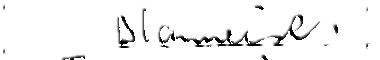

Erkanntes Wort: ii-alomooixzoii


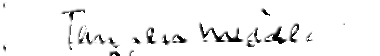

Erkanntes Wort: i-janittitsmaithis


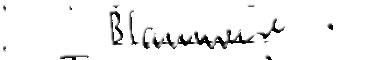

Erkanntes Wort: iii-blpmsapeit


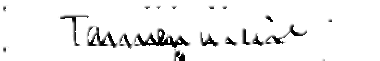

Erkanntes Wort: itansuslepislist-


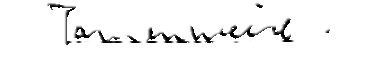

Erkanntes Wort: totashatwvesif


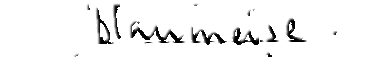

Erkanntes Wort: byaxlneirsosis


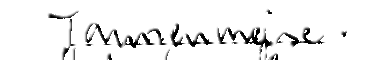

Erkanntes Wort: iinanhamzeuranvs3e-


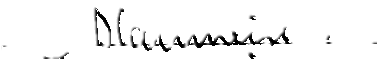

Erkanntes Wort: -is1lallicassii


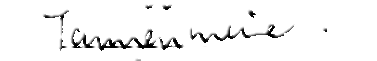

Erkanntes Wort: toitimantnmie


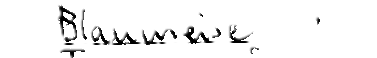

Erkanntes Wort: 7desasiemifis


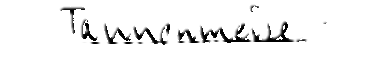

Erkanntes Wort: tiaeniinmeinie


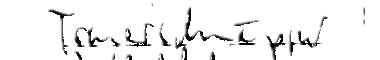

Erkanntes Wort: itsineisigheritfifai


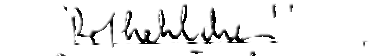

Erkanntes Wort: hesinhehldisni


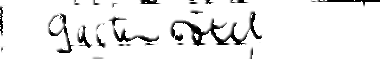

Erkanntes Wort: iiaifeit-yeis-del-m-


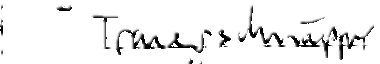

Erkanntes Wort: isfannssiisihrsapory


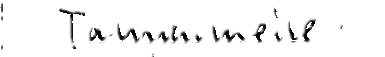

Erkanntes Wort: toinussterinitiisli


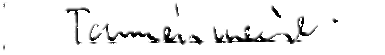

Erkanntes Wort: itonitomsekisinil-


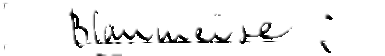

Erkanntes Wort: iibiansoebsatiixita


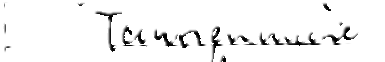

Erkanntes Wort: iisisfermnyfaamsewie


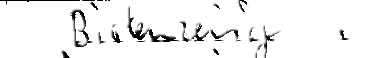

Erkanntes Wort: bintersfy


In [ ]:
import re

file_path = '/content/drive/MyDrive/Scans/notebooks/Daten - DH/Daten/vogelarten.txt'
predefined_words = []

def replace_umlauts(word):
    # Replace German umlauts with their equivalents
    word = word.replace('ä', 'ae')
    word = word.replace('ö', 'oe')
    word = word.replace('ü', 'ue')
    word = word.replace('ß', 'ss')
    # Add more replacements if needed (e.g., ß -> ss)

    return word

with open(file_path, 'r', encoding='utf-8') as file:
    predefined_words = file.readlines()

# Regex-Pattern für den deutschen Vogelnamen
pattern = re.compile(r'^([^\(]+)')
vogelnamen_liste = []

for line in predefined_words:
    match = re.findall(pattern, line.strip())
    if match:
        vogelnamen_liste.append(replace_umlauts(match[0].lower()))

for exImg in exampleImages:
  cv2_imshow(exImg)

  line_clustering_config = LineClusteringConfig(min_words_per_line=1)
  reader_config = ReaderConfig(decoder="best_path", prefix_tree=PrefixTree(words=vogelnamen_liste))

  read_lines = read_page(exImg, DetectorConfig(scale=1, margin=10), line_clustering_config=line_clustering_config, reader_config=reader_config)
  recognized_words = []

  for read_line in read_lines:
      recognized_word = ''.join([read_word.text for read_word in read_line])
      recognized_word = recognized_word.lower()

      # Compare with predefined words
      matching_words = [word for word in vogelnamen_liste if sum([1 for a, b in zip(recognized_word, word) if a == b]) > 2]

      # Output matching words
      if matching_words:
          print(f"Erkanntes Wort: {recognized_word}")

Man sieht sehr gut, dass die HTR-Pipeline keines der Bilder richtig erkennen konnte, wodurch wir relativ schnell die Idee verworfen haben und uns auf das Training eines eigenen Datensatzes konzentriert haben.

*Remark*

*Es ist möglich dass die HTR Pipeline mit besseren Zellenbildern funktionieren könnte. Unter "Besser" versteht sich: Kein Noise oder Linien die nicht zum Text gehören, Textdicke und Textschärfe. Müsste man ausprobieren...*

### Texterkennung via CNN (eigener Datensatz)

Um die Texterkennung zu verbessern (oder erstmal grundlegend zum Laufen zu bringen) haben wir uns entschieden ein eigenes CNN mit eigenen Daten zu trainieren.

Dazu haben wir für die meisten Vogelarten entsprechende Zellen segmentiert und augmentiert. Das Erkennen von Vogelarten ist dadurch möglich geworden (wenn auch noch sehr wechselhaft).

Man dürfte das Ergebnis hier sehr wahrscheinlich verbessern können, indem man mehr und bessere (siehe oben) Daten zum Training bereitsstellt.

**Warum nicht mehr Daten?**

Wir haben für das Erstellen eines Datensatzes (28 Vogelarten a 100 Bilder) knapp 4 Stunden zu dritt gebraucht. Die Zeit wollten wir nicht jedes mal aufs neue investieren, solange wir nicht mit der Nachbearbeitung der Zellen zufrieden sind. Dazu kommt dass die Zeit gegen Ende einfach nicht mehr dafür gereicht hat.

In [ ]:
# Zelle auskommentieren um Bilder von unterrepräsentierten Klassen zu augmentieren
#
#
#
#
#
#def augment_images(class_dir, augment_factor):
#    datagen = ImageDataGenerator(
#        rotation_range=3,
#        width_shift_range=0.02,
#        height_shift_range=0.01,
#        shear_range=0.1,
#        zoom_range=0.03,
#        horizontal_flip=False,
#        fill_mode='nearest')
#
#    images = os.listdir(class_dir)
#    num_images = len(images)
#    num_augment = int(augment_factor * num_images)
#
#    for i in range(num_augment):
#        img_name = random.choice(images)
#        img_path = os.path.join(class_dir, img_name)
#        img = load_img(img_path)
#        img_array = img_to_array(img)
#        img_array = img_array.reshape((1,) + img_array.shape)
#
#        for batch in datagen.flow(img_array, batch_size=1,
#                                  save_to_dir=class_dir,
#                                  save_prefix='copy',
#                                  save_format='png'):
#            break  # Stop after one image to prevent infinite loop
#
## Beispiel, um Klasse 3 zu augmentieren
#augment_images('/content/drive/MyDrive/Scans/notebooks/Daten - DH/Vogelarten/xy', 2)  # Verdoppelt die Anzahl der Bilder in Klasse xy
#

In [ ]:
base_dir = '/content/drive/MyDrive/Scans/notebooks/Daten - DH/Vogelarten'

# Bildgrößen und Batchgröße definieren
img_height, img_width = 22, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

# Keine Datenanreicherung für Validierungsdaten
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# CNN Modell erstellen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(train_generator.class_indices), activation='softmax')
])

## Speichern der Klassenindizes
#class_indices = train_generator.class_indices
#with open('/content/drive/MyDrive/Scans/class_indices.json', 'w') as file:
#    json.dump(class_indices, file)
#
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])
#
## Callbacks definieren
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Scans/notebooks/Daten - DH/vogelarten_best_model.keras', save_best_only=True)
#
## Modell trainieren
#history = model.fit(
#    train_generator,
#    steps_per_epoch=train_generator.samples // batch_size,
#    epochs=50,  # Anzahl der Epochen kann angepasst werden
#    validation_data=validation_generator,
#    validation_steps=validation_generator.samples // batch_size,
#    callbacks=[early_stopping, model_checkpoint]
#)
#
# Modell speichern
#model.save('/content/drive/MyDrive/Scans/notebooks/Daten - DH/vogelarten_final_model.keras')

Found 2240 images belonging to 28 classes.
Found 560 images belonging to 28 classes.


In [ ]:
# Funktion zum Anzeigen von Bildern
def show_images(images_arr, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generieren von Bildern aus dem Trainingsdatengenerator
sample_training_images, _ = next(train_generator)

# Anzeigen der ersten 5 Bilder
show_images(sample_training_images[:5])


In [ ]:
# Modell laden
model = load_model('/content/drive/MyDrive/Scans/Models/vogelarten_best_model.keras')

# Klassenindizes und deren Namen abrufen
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Testbild vorbereiten
img_path = '/content/drive/MyDrive/Scans/notebooks/Daten - DH/Fitis_test.png'
img = image.load_img(img_path, target_size=(22, 150))
display(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalisieren

# Vorhersage machen
predictions = model.predict(img_array)

# Vorhergesagte Klasse interpretieren
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = index_to_class[predicted_class_index]
print("Vorhergesagte Klasse:", predicted_class_name)



1/1 [==============================] - 0s 224ms/step
Vorhergesagte Klasse: Fitis


In [ ]:
# Vorhersagen für den Validierungsdatensatz
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tatsächliche Klassenlabels
y_true = validation_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

18/18 [==============================] - 130s 8s/step
                     precision    recall  f1-score   support

                  "       0.05      0.05      0.05        20
         Alpenmeise       0.05      0.05      0.05        20
         Baumpieper       0.00      0.00      0.00        20
       Birkenzeisig       0.00      0.00      0.00        20
          Blaumeise       0.06      0.05      0.06        20
       Braunkelchen       0.03      0.05      0.04        20
         Distelfink       0.05      0.05      0.05        20
        Erlenzeisig       0.00      0.00      0.00        20
              Fitis       0.06      0.05      0.05        20
   Gartenrotschwanz       0.06      0.05      0.05        20
       Gartenrötel       0.05      0.05      0.05        20
        Gelbspöter       0.00      0.00      0.00        20
            Girlitz       0.00      0.00      0.00        20
     Grauschnäpper       0.00      0.00      0.00        20
     Hausrotschwanz       0.05

Die Ergebnisse sehen sehr ernüchternd auf den ersten Blick aus sind aber schoneinmal ein Anfang. Wie man auch später bei der Anwendung sehen kann, funktioniert das Erkennen besser als aus den Metriken erwartet.

Wie bereits gesagt dürften sich die Metriken mit mehr und besseren Daten verbessern.

### Zahlenerkennung via MNIST

Zur Erkennung der handgeschriebenen Zahlen haben wir uns den MNIST Datensatz zu nutzen gemacht und anhand davon ein CNN trainiert.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('/content/drive/MyDrive/Scans/Models/mnist_cnn_model.keras')


In [ ]:
model = load_model('/content/drive/MyDrive/Scans/Models/mnist_cnn_model.keras')

# Laden Sie das trainierte Modell, falls nicht bereits im Speicher
# model = load_model('mnist_cnn_model.h5')

# Vorhersagen auf den Testdaten
predictions = model.predict(x_test)

# Umwandeln der Vorhersagen von One-Hot-Kodierung zu Klassenlabels
predicted_classes = np.argmax(predictions, axis=1)

# Umwandeln der wahren Labels von One-Hot-Kodierung zu Klassenlabels
true_classes = np.argmax(y_test, axis=1)

# Generieren des Klassifizierungsberichts
report = classification_report(true_classes, predicted_classes, target_names=[str(i) for i in range(10)], digits=4)

print(report)

### Anwendung: Zahlenerkennung (MNIST) & Texterkennung (eigener Datensatz)

Als letzten Schritt wenden wir unsere trainierten Models an unseren segmentierten Daten an und speichern (optional) das Ergebnis in eine CSV Datei.

Da der MNIST Datensatz anhand von einzelnen Ziffern (0-9) trainiert wurde, segmentieren wir aus der Zelle die einzelnen Ziffern heraus bevor wir das Model predicten lassen.

Auch hier kann die Segmentierung noch verbessert werden, da immernoch Noise im Bild vorhanden ist oder die Segmentierung nicht funktioniert und dadurch falsche (größere) Zahlen entstehen als eigentlich in der Zelle vorhanden sind.

In [ ]:
species_model_path = '/content/drive/MyDrive/Scans/Models/vogelarten_best_model.keras'
number_model_path = '/content/drive/MyDrive/Scans/Models/mnist_cnn_model.keras'
class_indices_path = '/content/drive/MyDrive/Scans/class_indices.json'
output_csv = '/content/drive/MyDrive/Scans/predictions.csv'
output_csv_nr = '/content/drive/MyDrive/Scans/predictions_numbers.csv'

species_model = load_model(species_model_path)
number_model = load_model(number_model_path)

with open(class_indices_path, 'r') as file:
  class_indices = json.load(file)

species_index_to_class = {v: k for k, v in class_indices.items()}

maxKernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))

csvSpecies = []
csvNr = []
for idx, extract in enumerate(table):
  index = 0

  for pNr, page in enumerate(extract):
    for rNr, row in enumerate(page):
      if idx == 0:
        csvSpecies.append([])

        data = cv.bitwise_not(row)

        # TODO: Resize image canvas to correct aspect ratio and center content

        cv.imwrite("tmp.png", row)

        species_img = image.load_img("tmp.png", target_size=(22, 150))
        species_img_array = image.img_to_array(species_img)
        species_img_array = np.expand_dims(species_img_array, axis=0)
        species_img_array /= 255.0

        species_predictions = species_model.predict(species_img_array)
        species_class_index = np.argmax(species_predictions, axis=1)[0]
        predictedSpecies = species_index_to_class[species_class_index]

        csvSpecies[index].append(pNr)
        csvSpecies[index].append(rNr)
        csvSpecies[index].append(predictedSpecies)

      elif idx == 1:
        csvNr.append([])

        data = cv.bitwise_not(row)

        # Remove (some) noise and increase contrast between lines and background
        componentsNumber, labeledImage, componentStats, componentCentroids = cv.connectedComponentsWithStats(data, connectivity=4)
        minArea = 40
        remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]
        data = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

        # Fix holes between lines of digits
        data = cv.morphologyEx(data, cv.MORPH_CLOSE, maxKernel, None, None, 1, cv.BORDER_REFLECT101)

        rowCopy = np.copy(data)
        rowCopy = cv.cvtColor(rowCopy,cv.COLOR_GRAY2RGB)

        # Find contour bounding boxes to cutout single digits
        contours, hierarchy = cv.findContours(data, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

        contours_poly = [None] * len(contours)
        boundRect = []

        for i, c in enumerate(contours):
            if hierarchy[0][i][3] == -1:
                contours_poly[i] = cv.approxPolyDP(c, 3, True)
                boundRect.append(cv.boundingRect(contours_poly[i]))

        # Draw the bounding boxes on the (copied) input image:
        for i in range(len(boundRect)):
            color = (0, 255, 0)
            #cv.rectangle(rowCopy, (int(boundRect[i][0]), int(boundRect[i][1])), \
            #          (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)

        boundRect.sort(key=lambda x: x[0])

        ziffer = ""
        for i in range(len(boundRect)):
          x, y, w, h = boundRect[i]

          # Try to remove detected noise bounding boxes, which are definitely no digits
          if w > h * 2:
            continue

          if h < 10:
            continue

          if w < 10:
            if h < 20:
              continue

          croppedImg = data[y:y + h, x:x + w]

          # Make cropped image rectangular and center it
          if w > h:
            canvas = np.zeros((w, w))

            offset = math.floor((w - h) / 2)
            offsetEnd = offset
            if offsetEnd * 2 < (w - h):
              offsetEnd = offsetEnd + 1

            canvas[offset:-offsetEnd, :] = croppedImg
            croppedImg = canvas
          elif h > w:
            canvas = np.zeros((h, h))

            offset = math.floor((h - w) / 2)
            offsetEnd = offset
            if offsetEnd * 2 < (h - w):
              offsetEnd = offsetEnd + 1

            canvas[:, offset:-offsetEnd] = croppedImg
            croppedImg = canvas

          # Resize cropped image to apply with cnn trained data
          croppedImg = cv.resize(croppedImg, dsize=(28, 28), interpolation=cv.INTER_CUBIC)
          cv2_imshow(croppedImg)
          croppedImg = np.expand_dims(croppedImg, axis=0)

          prediction = number_model.predict(croppedImg)
          predicted_digit = np.argmax(prediction)
          ziffer = ziffer + str(predicted_digit)

        predictedNumber = ziffer

        print("Predicted: ", predictedNumber)
        csvNr[index].append(pNr)
        csvNr[index].append(rNr)
        csvNr[index].append(predictedNumber)

      index = index + 1

csvSpecies = pd.DataFrame(csvSpecies, columns=["Seite", "Zeile", "Predicted_Species"])
csvNr = pd.DataFrame(csvNr, columns=["Seite", "Zeile", "Predicted_Number"])

# Uncomment to save csv
#csvSpecies.to_csv(output_csv, index=False)
#csvNr.to_csv(output_csv_nr, index=False)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 56ms/step
Predicted:  4


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  77


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  48


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  84


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  61


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  88


1/1 [==============================] - 0s 16ms/step
Predicted:  2


1/1 [==============================] - 0s 16ms/step
Predicted:  4


1/1 [==============================] - 0s 32ms/step
Predicted:  3


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  661


1/1 [==============================] - 0s 35ms/step
Predicted:  7


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  62


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 68ms/step
Predicted:  62


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  68


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 58ms/step
Predicted:  81


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 56ms/step
Predicted:  641


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 51ms/step
Predicted:  66


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 43ms/step
Predicted:  83


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  7023


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 29ms/step
Predicted:  34


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  10


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  01


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  643
Predicted:  


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  41


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  24


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  55


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  76


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  80


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  10


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  41


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  176


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  64


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  66


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  67


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  636


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  621


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  663


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  66


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  26


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  64


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  76


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  71


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  65


1/1 [==============================] - 0s 15ms/step
Predicted:  0


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  04


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  044


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  76


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  74


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 69ms/step
Predicted:  37


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  40


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  241
Predicted:  


1/1 [==============================] - 0s 15ms/step
Predicted:  1


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  615


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  48


1/1 [==============================] - 0s 19ms/step
Predicted:  0


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  86


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  46


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  67


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  78
Predicted:  


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  26


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  96


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  76


1/1 [==============================] - 0s 16ms/step
Predicted:  6


1/1 [==============================] - 0s 15ms/step
Predicted:  5


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  24


1/1 [==============================] - 0s 16ms/step
Predicted:  2


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  21


1/1 [==============================] - 0s 16ms/step
Predicted:  8


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  74


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  616


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  71


1/1 [==============================] - 0s 15ms/step
Predicted:  4


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  13


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  23


1/1 [==============================] - 0s 16ms/step
Predicted:  0


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  02


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  80


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  23


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  45


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  80


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  106


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  40


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  674


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  628


1/1 [==============================] - 0s 16ms/step
Predicted:  7


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  27


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  21


1/1 [==============================] - 0s 16ms/step
Predicted:  6


1/1 [==============================] - 0s 14ms/step
Predicted:  6


1/1 [==============================] - 0s 18ms/step
Predicted:  3


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  67


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  21


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  74


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 26ms/step
Predicted:  65
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  8


1/1 [==============================] - 0s 21ms/step
Predicted:  7


1/1 [==============================] - 0s 20ms/step
Predicted:  8


1/1 [==============================] - 0s 23ms/step
Predicted:  4


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  23
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  4


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  14


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 63ms/step
Predicted:  62


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 61ms/step
Predicted:  62


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  24


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  86


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  88


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  87


1/1 [==============================] - 0s 14ms/step
Predicted:  4


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  86


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  76


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  46


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  68


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  61


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  62


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  54


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  86


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  63


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  86


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  32


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  40


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  88


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  686


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  926


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  66


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  62


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 37ms/step
Predicted:  41


1/1 [==============================] - 0s 42ms/step
Predicted:  4


1/1 [==============================] - 0s 64ms/step
Predicted:  9


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 42ms/step
Predicted:  68


1/1 [==============================] - 0s 25ms/step
Predicted:  8


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  82


1/1 [==============================] - 0s 23ms/step
Predicted:  4


1/1 [==============================] - 0s 34ms/step
Predicted:  0


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  67


1/1 [==============================] - 0s 17ms/step
Predicted:  2


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  63


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  68


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 46ms/step
Predicted:  881


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  47


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  46


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 47ms/step
Predicted:  87


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  42


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 75ms/step
Predicted:  37


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step
Predicted:  62


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  82


1/1 [==============================] - 0s 16ms/step
Predicted:  4


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  73


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 29ms/step
Predicted:  60


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  623
Predicted:  


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  825


1/1 [==============================] - 0s 28ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  09


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  09
Predicted:  
Predicted:  


1/1 [==============================] - 0s 15ms/step
Predicted:  1


1/1 [==============================] - 0s 15ms/step
Predicted:  6


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  4725


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  1545
Predicted:  


1/1 [==============================] - 0s 15ms/step
Predicted:  0
Predicted:  


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  1656


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  62
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  230
Predicted:  
Predicted:  


1/1 [==============================] - 0s 15ms/step
Predicted:  5


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  6916
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 61ms/step
Predicted:  64


1/1 [==============================] - 0s 25ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  56
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  186
Predicted:  
Predicted:  


1/1 [==============================] - 0s 29ms/step
Predicted:  6


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  04
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  7


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  046
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 28ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  4


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  865


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  65


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  726


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step
Predicted:  66


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  81


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  71


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  870


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  666


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  61


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  784


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  477


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  81


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  89


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  741


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  11


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  24


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  73


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  30


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 62ms/step
Predicted:  82


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  221


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  26


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  20


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  91


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  20


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  42


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  324


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  45


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  866


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  84


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  83


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  81


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  79


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  87


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  661


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  602


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  57


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  64


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 61ms/step
Predicted:  66


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  066


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  66


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  81


1/1 [==============================] - 0s 16ms/step
Predicted:  5


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  64


1/1 [==============================] - 0s 28ms/step
Predicted:  7


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  61


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  46


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  62


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  62
Predicted:  


1/1 [==============================] - 0s 17ms/step
Predicted:  4


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  6062


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  672


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  616


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  64


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  631


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  22


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  66647


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  46


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  274


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  761


1/1 [==============================] - 0s 15ms/step
Predicted:  4


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  640


1/1 [==============================] - 0s 25ms/step
Predicted:  4


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  15


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  661


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 35ms/step
Predicted:  1621


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 38ms/step
Predicted:  163


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  65


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  641


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  6241


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  0227


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 39ms/step
Predicted:  811


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  662


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  80


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  202


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  202


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  144


1/1 [==============================] - 0s 16ms/step
Predicted:  1


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  34


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  64


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  26


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  41


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  176


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  74


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  81


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  43


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step
Predicted:  183


1/1 [==============================] - 0s 21ms/step
Predicted:  4


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  71


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  52


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  23


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  221


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  21


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  21


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  26


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  26


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 85ms/step
Predicted:  470


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  21


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  72


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  621


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  22
Predicted:  


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  641


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  663


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  651


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  65


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  63
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  8


1/1 [==============================] - 0s 23ms/step
Predicted:  4


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  84


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  81


1/1 [==============================] - 0s 21ms/step
Predicted:  2
Predicted:  
Predicted:  


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step
Predicted:  26
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 18ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 16ms/step
Predicted:  1


1/1 [==============================] - 0s 19ms/step
Predicted:  1


1/1 [==============================] - 0s 15ms/step
Predicted:  8


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  146
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 16ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 19ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  61


1/1 [==============================] - 0s 17ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  7


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  83
Predicted:  


1/1 [==============================] - 0s 26ms/step
Predicted:  6


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  241
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 19ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  7


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  41
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  16
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 41ms/step
Predicted:  670


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  96
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  9


1/1 [==============================] - 0s 52ms/step
Predicted:  4
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 61ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  841


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  63


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  43


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 40ms/step
Predicted:  244


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  26


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  53


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 39ms/step
Predicted:  66


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 70ms/step
Predicted:  21


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  62


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  63


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 37ms/step
Predicted:  66


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 44ms/step
Predicted:  63


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  46


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  46


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  60


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 66ms/step
Predicted:  66


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  66


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  703


1/1 [==============================] - 0s 21ms/step
Predicted:  2


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  60


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  60


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  51


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  64


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  046


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  646


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  66


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  66


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 34ms/step
Predicted:  63


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  61


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  61


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  81


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 42ms/step
Predicted:  64


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  622


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  66


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 54ms/step
Predicted:  642


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  66


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 90ms/step
Predicted:  65


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  780


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  66


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  66


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  866


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  62


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  66


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  646


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  64


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 37ms/step
Predicted:  61


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  46


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  4761


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  404


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  48


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  66
Predicted:  


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  02


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  266


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  2661


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  802


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  446


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 63ms/step
Predicted:  46


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  81


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  265


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 34ms/step
Predicted:  83


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step
Predicted:  801


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  48


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  80


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  44


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  80


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  721


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  4876


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  86


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step
Predicted:  82


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  2804


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  28


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  82


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  73


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  28


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  22


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  1405


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  729


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  81


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  800


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  901


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step
Predicted:  82


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  22


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  71


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  720


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
Predicted:  226


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  07


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  6291


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  75


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  6760


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
Predicted:  64


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  83


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Predicted:  262


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
Predicted:  13


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  16


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  63


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step
Predicted:  66


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step
Predicted:  67


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 29ms/step
Predicted:  666
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  0
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 35ms/step
Predicted:  7


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 82ms/step
Predicted:  44


1/1 [==============================] - 0s 39ms/step
Predicted:  6


1/1 [==============================] - 0s 22ms/step
Predicted:  1


1/1 [==============================] - 0s 34ms/step
Predicted:  1


1/1 [==============================] - 0s 45ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 32ms/step
Predicted:  6


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  11
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step
Predicted:  6


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  42


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  96


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 35ms/step
Predicted:  56
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 35ms/step
Predicted:  1


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 40ms/step
Predicted:  146
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  41
Predicted:  


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 59ms/step
Predicted:  1717


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 38ms/step
Predicted:  661


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 38ms/step
Predicted:  45


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 60ms/step
Predicted:  84
Predicted:  


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  04


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step
Predicted:  86


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 71ms/step
Predicted:  23


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step
Predicted:  28


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  66


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 35ms/step
Predicted:  42
Predicted:  
Predicted:  


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 44ms/step
Predicted:  26


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step
Predicted:  466
Predicted:  


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 38ms/step
Predicted:  424


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 36ms/step
Predicted:  14
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 28ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 30ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 36ms/step
Predicted:  4
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 40ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 37ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 37ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step
Predicted:  11
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 35ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step
Predicted:  11
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  14


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 24ms/step
Predicted:  6


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  1


1/1 [==============================] - 0s 27ms/step
Predicted:  6


1/1 [==============================] - 0s 25ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 29ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 27ms/step
Predicted:  1


1/1 [==============================] - 0s 22ms/step
Predicted:  1


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 70ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  12
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  02


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  16106


1/1 [==============================] - 0s 22ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  141
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step
Predicted:  11
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 29ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 30ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1


1/1 [==============================] - 0s 23ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  162
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 44ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  411
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 31ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 26ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 55ms/step
Predicted:  6
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  61
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  11
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  13
Predicted:  


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 48ms/step
Predicted:  60


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  66
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 30ms/step
Predicted:  4
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  6
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  6


1/1 [==============================] - 0s 21ms/step
Predicted:  1


1/1 [==============================] - 0s 23ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted:  27
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  6
Predicted:  
Predicted:  


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 28ms/step
Predicted:  8
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  14
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 26ms/step
Predicted:  2


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 36ms/step
Predicted:  882


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  44
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  45


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  23


1/1 [==============================] - 0s 21ms/step
Predicted:  4


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 34ms/step
Predicted:  071


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 23ms/step
Predicted:  7377


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 87ms/step
Predicted:  872


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 72ms/step
Predicted:  136


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 70ms/step
Predicted:  85


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  11


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  44


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step
Predicted:  41


1/1 [==============================] - 0s 19ms/step
Predicted:  4


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 29ms/step
Predicted:  7671


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step
Predicted:  43


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 24ms/step
Predicted:  64
Predicted:  


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 39ms/step
Predicted:  1
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step
Predicted:  4
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  666
Predicted:  


1/1 [==============================] - 0s 20ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  4
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 24ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step
Predicted:  41
Predicted:  


1/1 [==============================] - 0s 71ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 113ms/step
Predicted:  1
Predicted:  


1/1 [==============================] - 0s 93ms/step
Predicted:  6
Predicted:  


1/1 [==============================] - 0s 68ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 31ms/step
Predicted:  6


1/1 [==============================] - 0s 25ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 45ms/step
Predicted:  1


1/1 [==============================] - 0s 59ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 22ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  4
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 28ms/step
Predicted:  1
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 21ms/step
Predicted:  6
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  
Predicted:  


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Predicted:  11
Predicted:  
Predicted:  


1/1 [==============================] - 0s 31ms/step
Predicted:  1
Predicted:  


## Ergebnisauswertung der Zahlenerkennung

Nachdem unser trainiertes Model (MNIST Datensatz) Ziffer für Ziffer in einer Zelle erkennt und vorhersagt, muss man auch das Model dementsprechend bewerten.

Wir haben hierfür alle erkannten Ziffern in einem PDF mit dem echten Wert verglichen und geschaut wie unser Model insgesamt abschneidet.

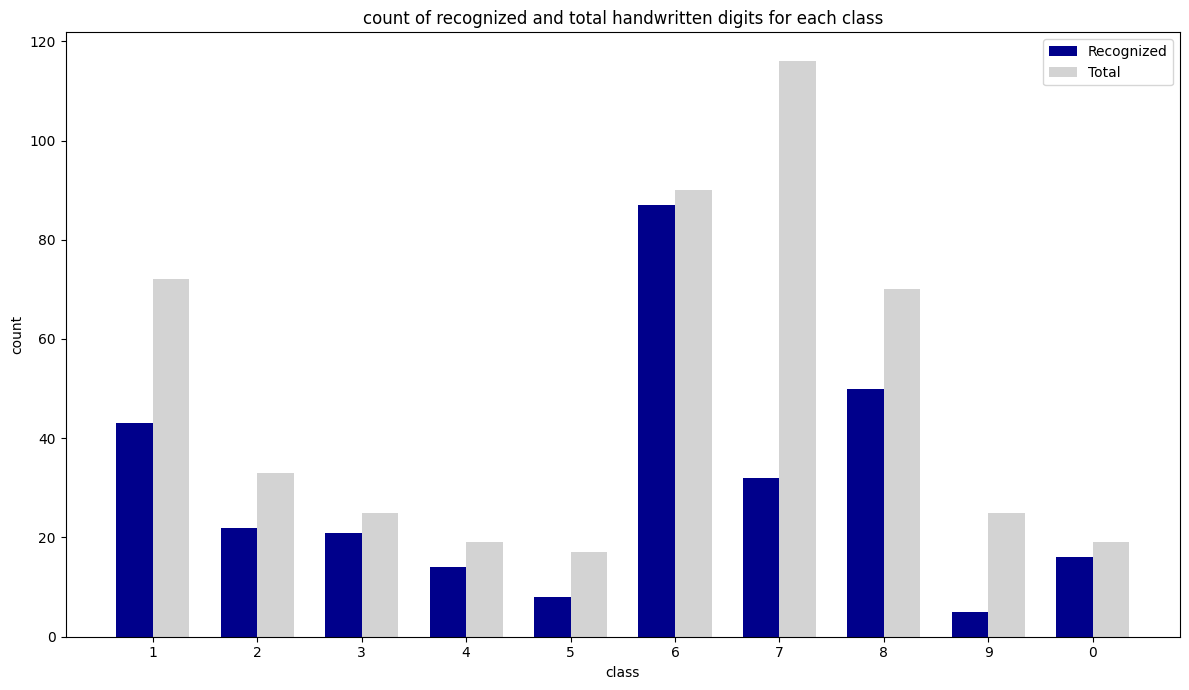

In [ ]:
import matplotlib.pyplot as plt
counts = {
    "1": (43, 72),
    "2": (22, 33),
    "3": (21, 25),
    "4": (14, 19),
    "5": (8, 17),
    "6": (87, 90),
    "7": (32, 116),
    "8": (50, 70),
    "9": (5, 25),
    "0": (16, 19)
}

labels = list(counts.keys())
recognized = [counts[label][0] for label in labels]
total = [counts[label][1] for label in labels]

plt.figure(figsize=(12, 7))
bar_width = 0.35
index = range(len(labels))

bar1 = plt.bar(index, recognized, bar_width, label='Recognized', color='darkblue')
bar2 = plt.bar([i + bar_width for i in index], total, bar_width, label='Total', color='lightgrey')

plt.xlabel('class')
plt.ylabel('count')
plt.title('count of recognized and total handwritten digits for each class')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

plt.tight_layout()
plt.show()

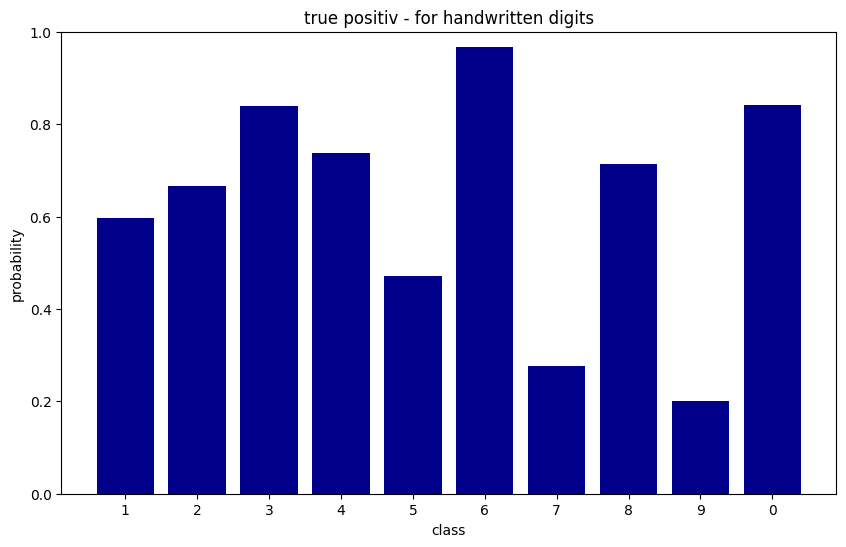

In [ ]:
probabilities = {
    "1": 43/72,
    "2": 22/33,
    "3": 21/25,
    "4": 14/19,
    "5": 8/17,
    "6": 87/90,
    "7": 32/116,
    "8": 50/70,
    "9": 5/25,
    "0": 16/19
}

labels = list(probabilities.keys())
values = [probabilities[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='darkblue')
plt.xlabel('class')
plt.ylabel('probability')
plt.title('true positiv - for handwritten digits')
plt.ylim(0, 1)
plt.show()

Rechnet man alle Wahrscheinlichkeiten zusammen kommen wir auf **~61%** Genauigkeit beim Erkennen einzelner Ziffern.

Man sieht auch gut das manche Ziffern sehr gut erkannt werden (6) und andere kaum (7 & 9). Das kann am MNIST Datensatz liegen oder aber auch an unseren Bildern der Ziffern.

## Auswertung Insgesamt



Auf dem Bild unten sieht man beispielhaft eine Auswertung für eine Seite im PDF.

- Vogelarten werden besser erkannt als vermutet
- Zahlen werden kaum komplett richtig erkannt (vergleicht man aber einzelne Ziffern kommt man wieder auf seine ~61%)



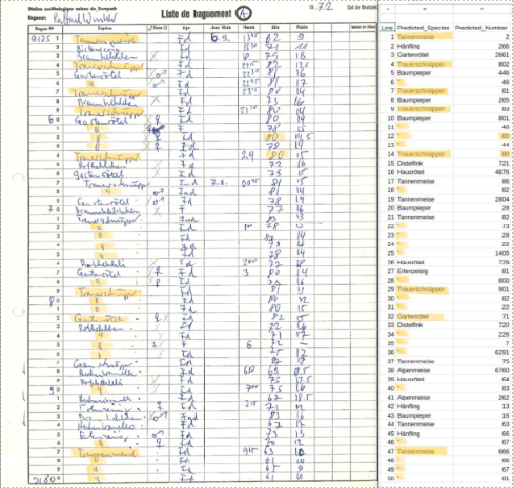

In [ ]:
img_path = '/content/drive/MyDrive/Scans/Auswertung.png'
img = image.load_img(img_path, target_size=(488, 513))
display(img)

## Ausblick

- Mehr Daten zum Trainieren werden benötigt
- Bessere Nachbearbeitung der Zellen notwendig um das Erkennen zu verbessern (CNN + Autoencoder zur Noise Reduction könnte hier ein gutes Mittel darstellen)
- Erkennung der Tabellenstruktur lässt sich vermutlich auch über ein Neuronales Netz besser lösen als durch OpenCV
- Es fehlen noch französische Vogelnamen, andere Tabellenformate (aktuellere PDFs), weitere Spalten


### Ausblick Nachbearbeitung:

Durch schärfen des Textes und finden von Konturen kann man sehr viel der überbliebenen Ränder ausschneiden. Folgendes Code-Snippet zeigt die Bounding Boxes eingezeichnet in der Zelle. Grün würde bleiben, Blau würde verschwinden .

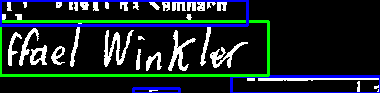

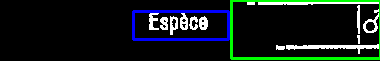

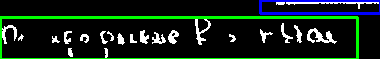

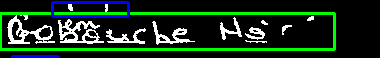

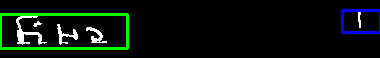

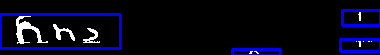

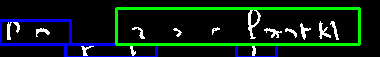

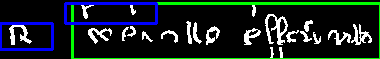

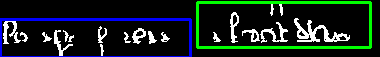

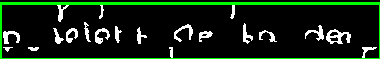

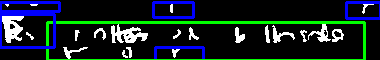

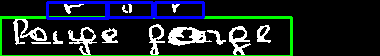

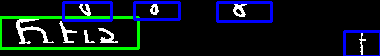

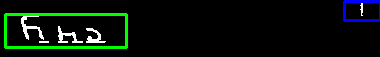

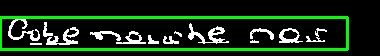

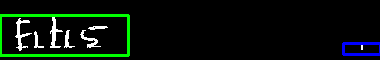

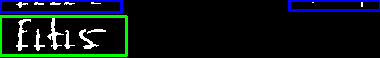

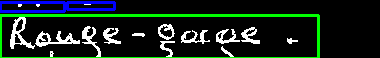

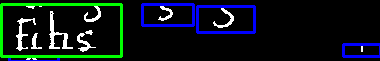

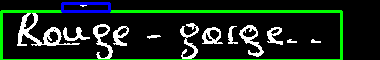

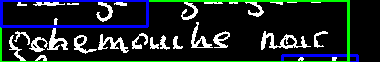

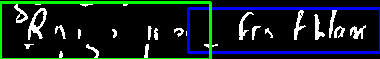

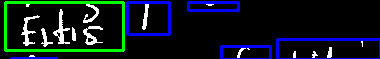

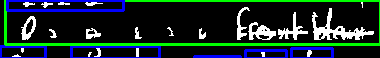

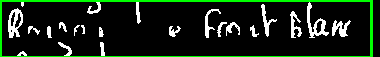

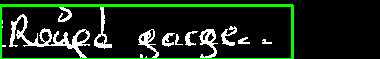

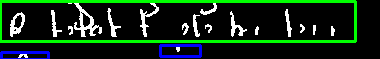

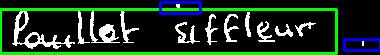

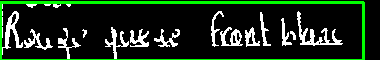

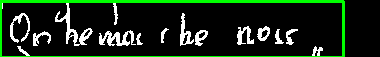

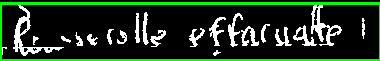

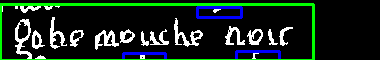

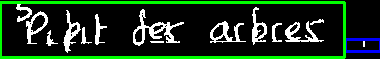

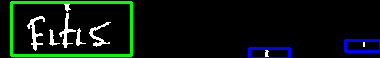

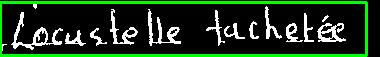

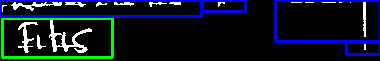

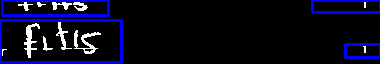

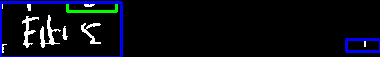

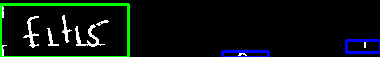

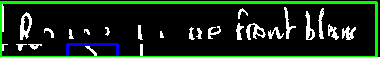

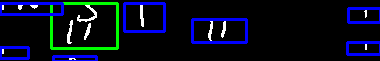

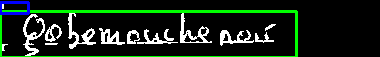

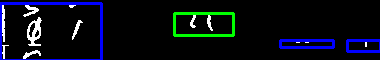

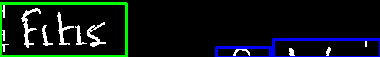

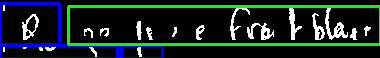

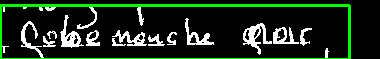

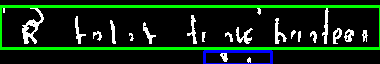

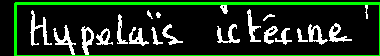

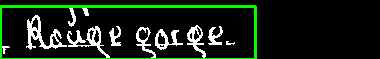

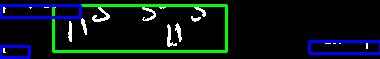

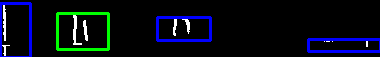

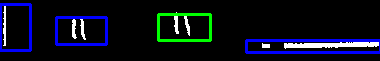

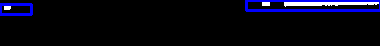

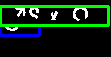

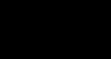

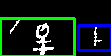

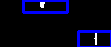

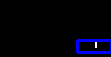

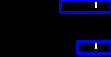

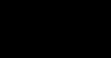

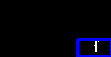

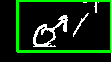

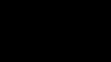

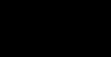

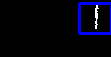

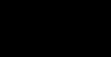

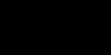

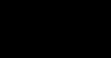

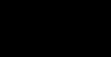

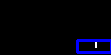

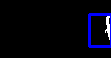

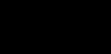

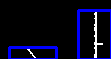

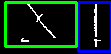

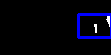

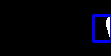

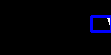

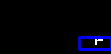

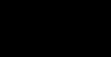

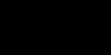

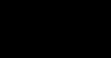

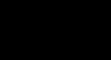

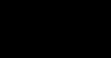

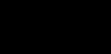

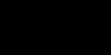

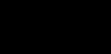

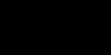

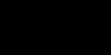

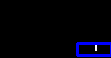

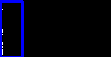

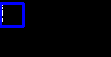

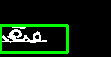

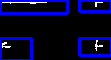

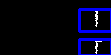

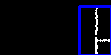

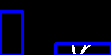

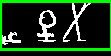

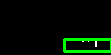

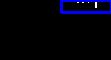

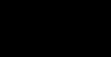

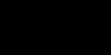

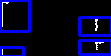

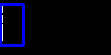

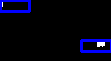

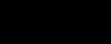

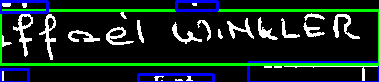

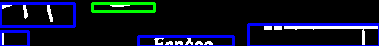

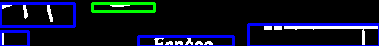

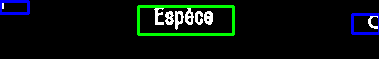

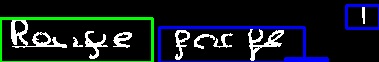

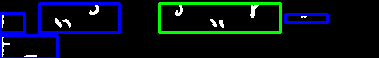

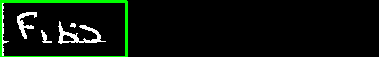

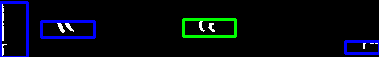

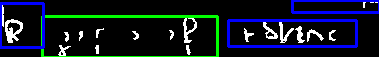

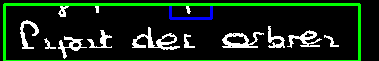

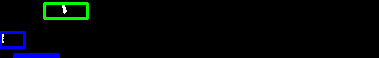

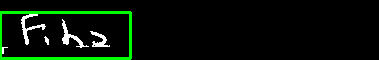

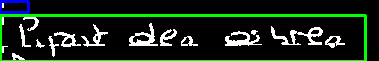

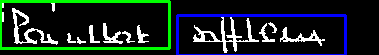

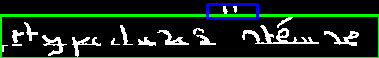

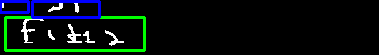

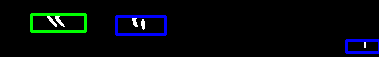

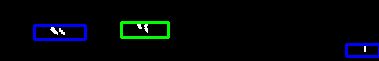

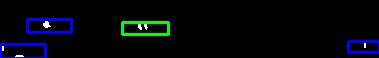

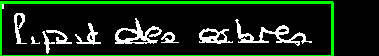

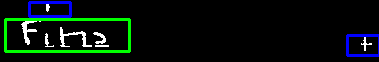

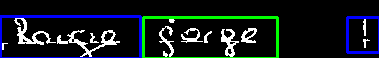

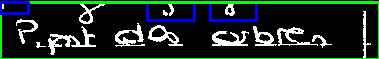

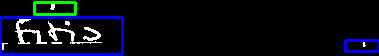

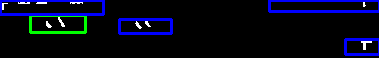

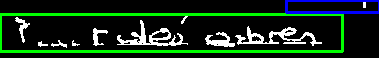

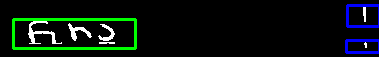

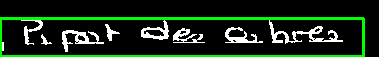

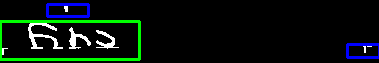

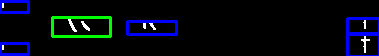

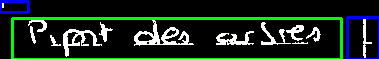

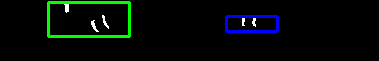

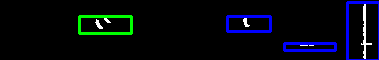

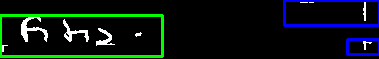

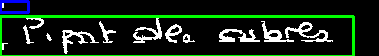

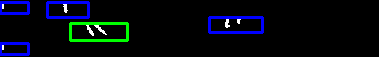

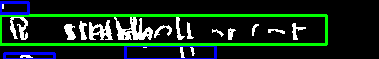

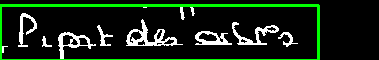

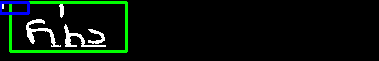

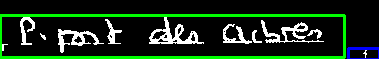

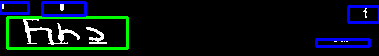

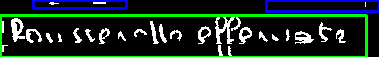

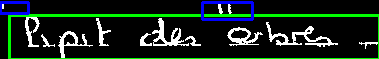

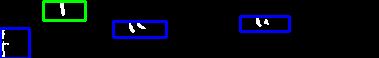

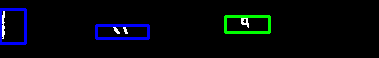

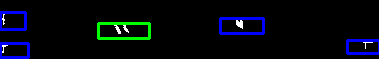

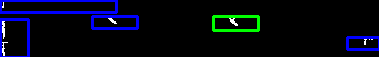

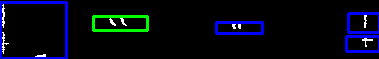

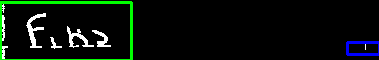

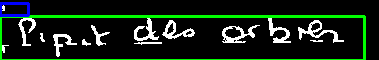

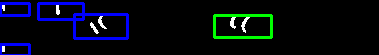

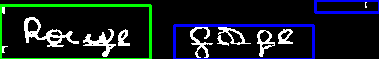

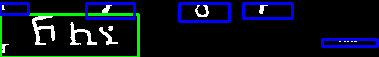

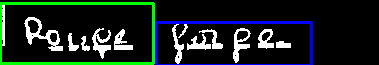

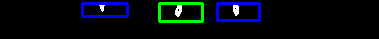

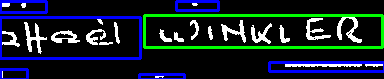

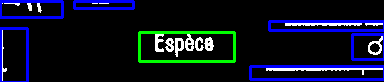

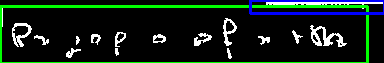

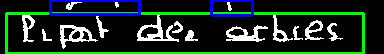

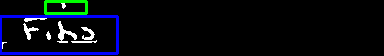

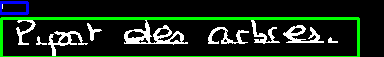

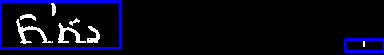

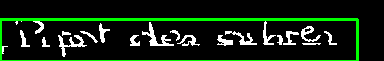

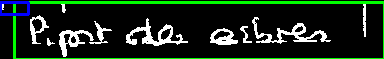

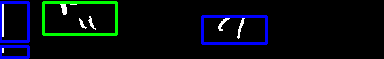

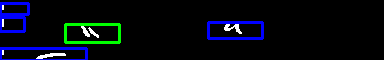

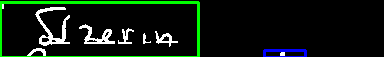

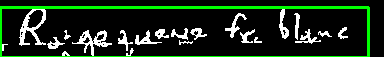

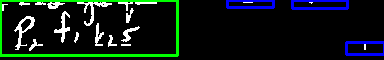

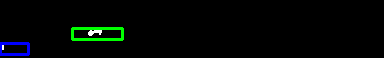

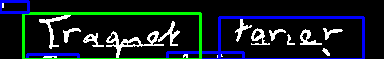

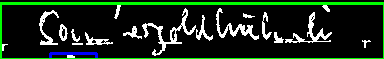

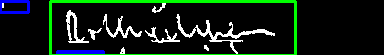

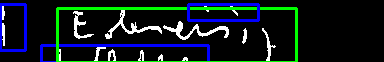

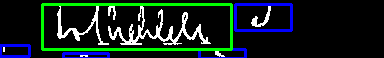

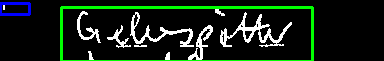

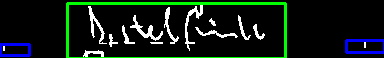

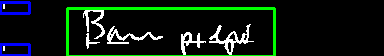

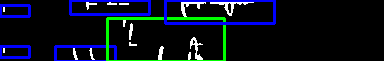

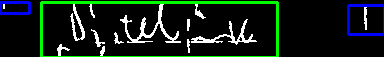

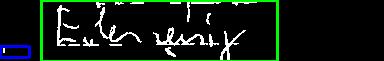

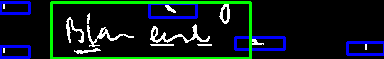

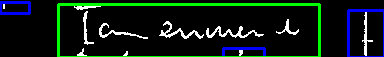

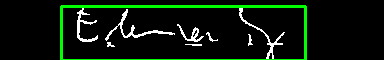

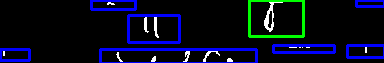

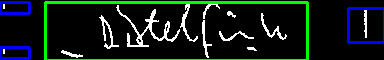

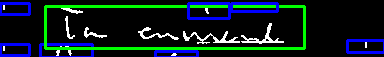

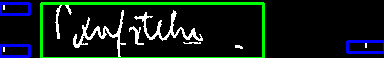

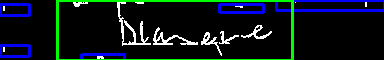

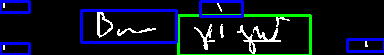

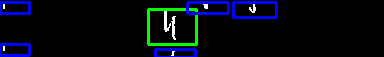

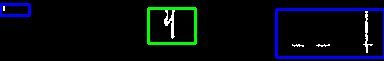

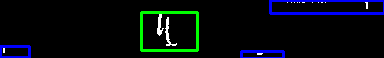

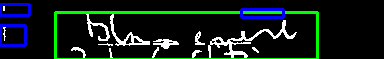

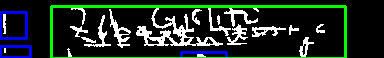

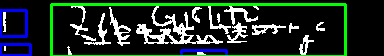

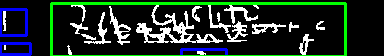

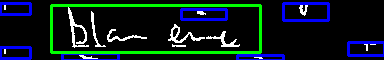

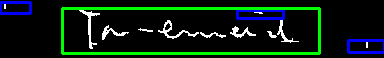

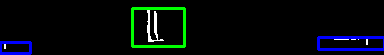

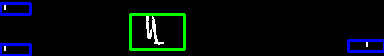

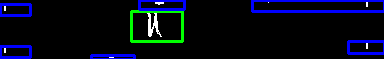

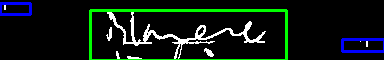

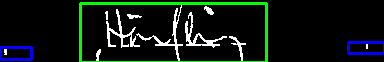

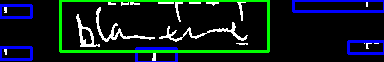

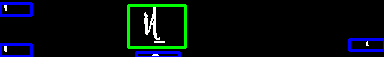

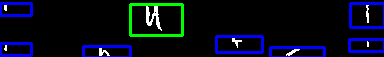

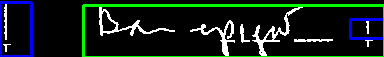

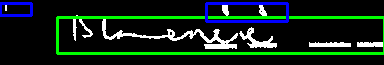

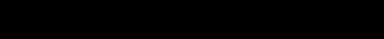

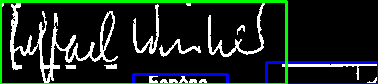

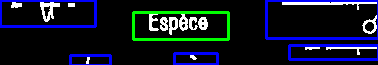

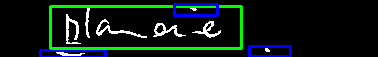

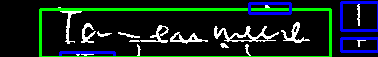

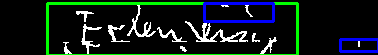

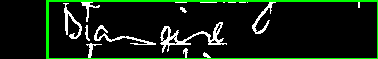

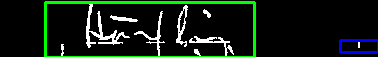

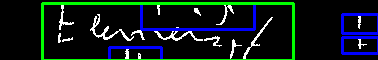

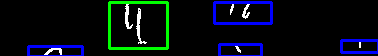

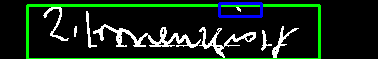

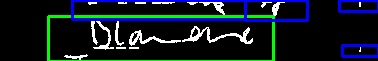

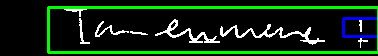

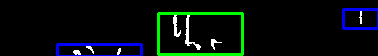

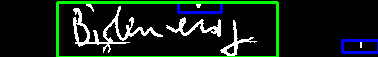

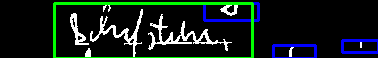

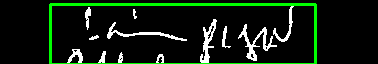

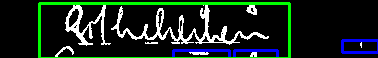

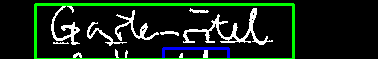

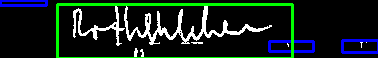

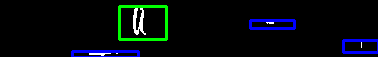

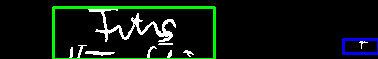

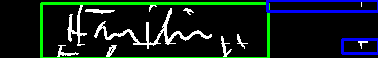

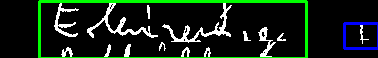

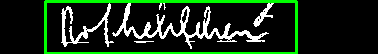

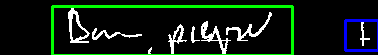

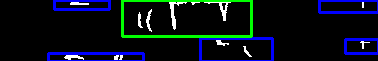

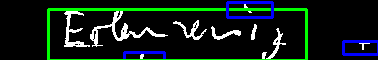

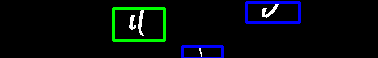

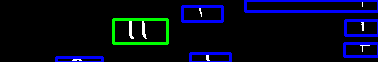

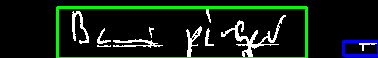

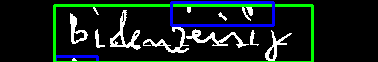

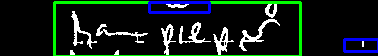

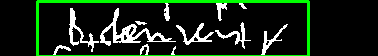

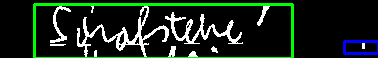

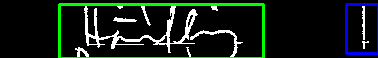

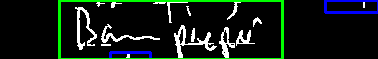

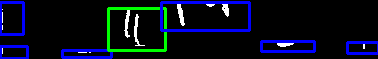

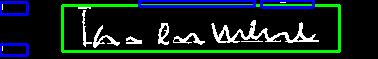

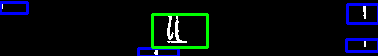

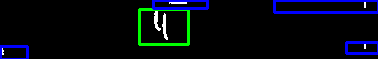

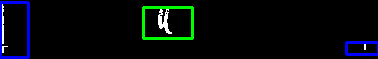

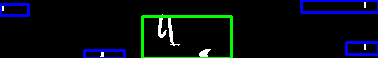

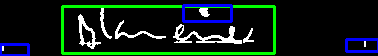

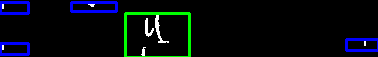

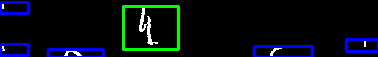

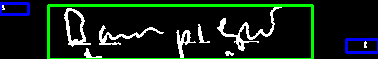

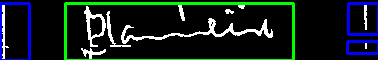

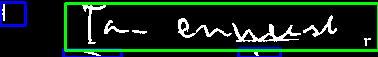

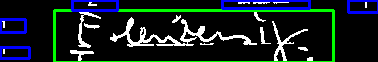

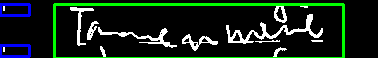

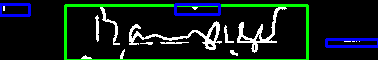

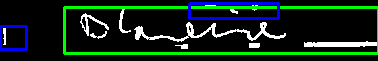

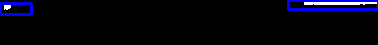

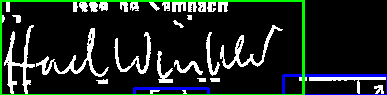

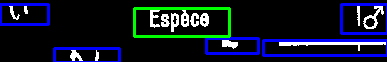

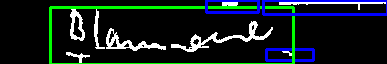

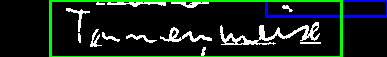

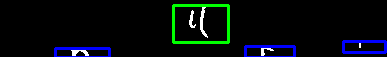

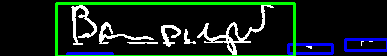

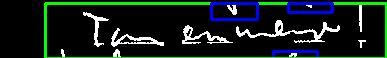

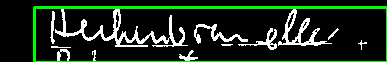

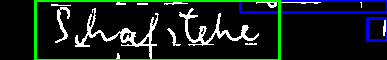

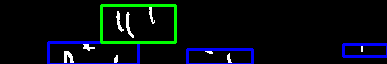

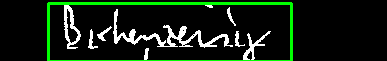

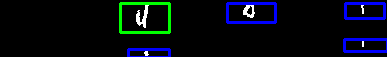

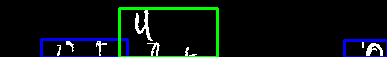

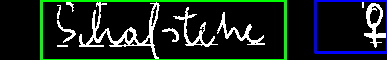

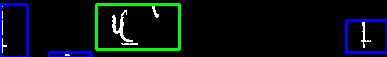

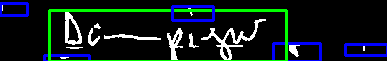

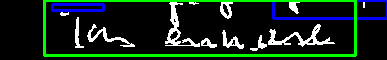

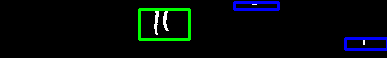

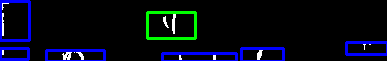

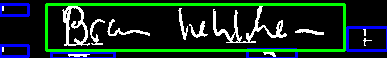

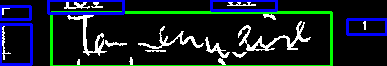

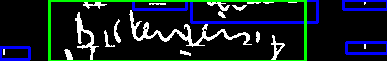

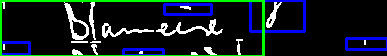

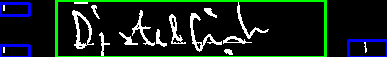

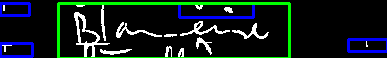

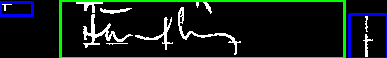

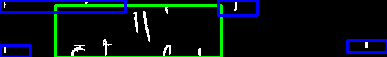

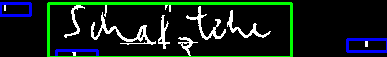

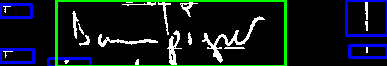

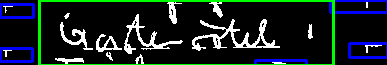

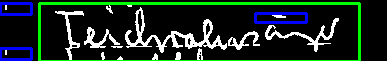

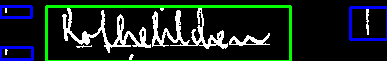

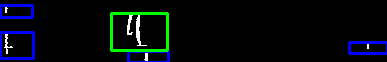

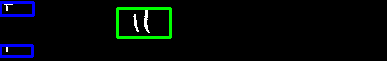

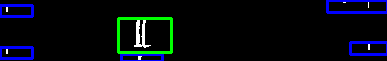

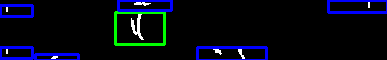

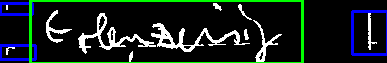

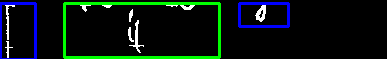

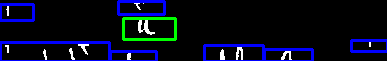

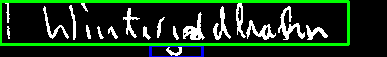

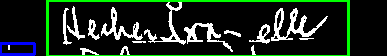

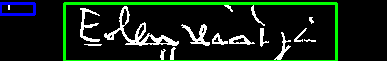

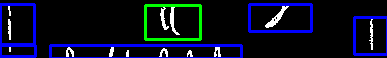

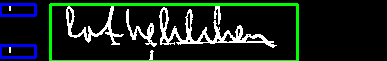

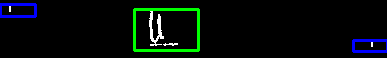

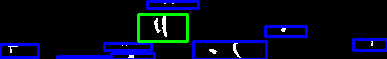

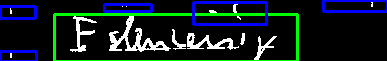

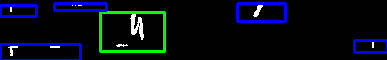

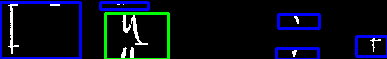

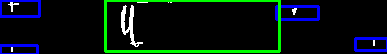

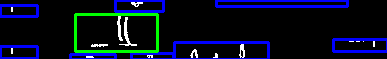

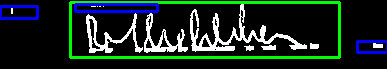

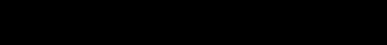

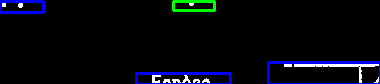

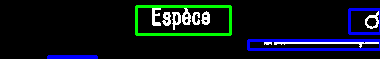

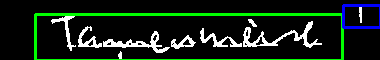

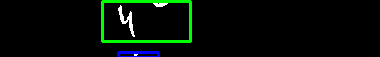

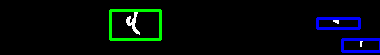

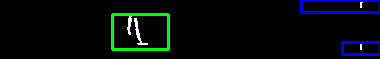

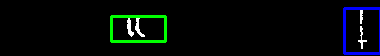

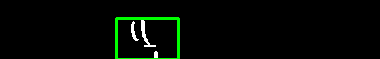

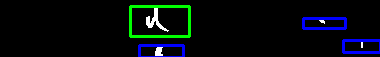

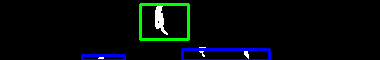

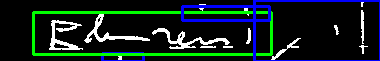

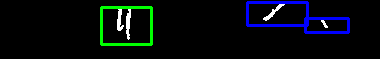

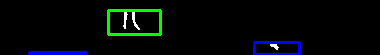

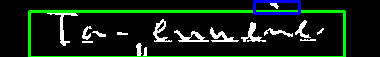

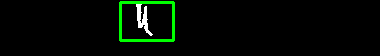

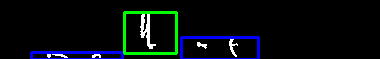

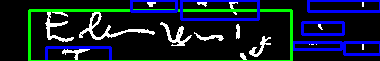

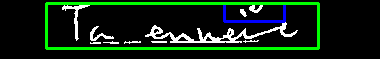

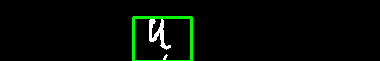

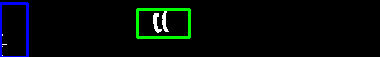

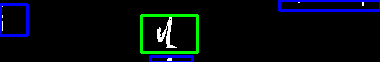

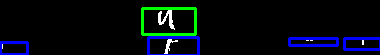

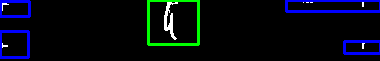

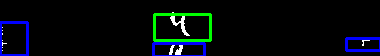

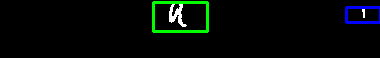

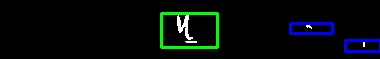

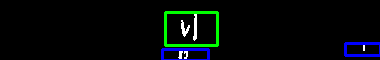

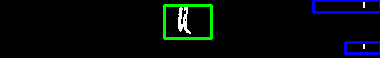

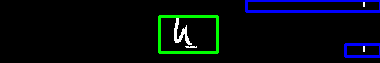

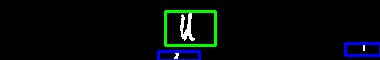

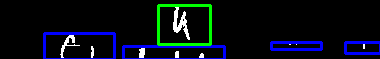

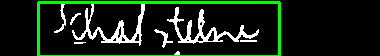

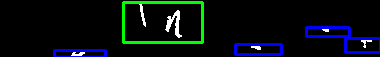

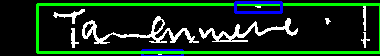

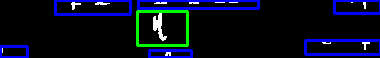

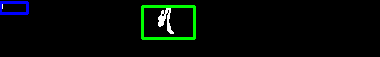

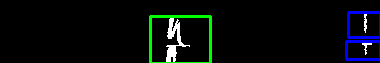

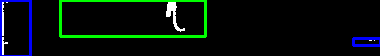

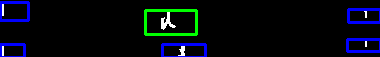

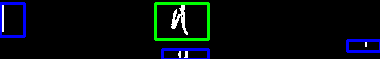

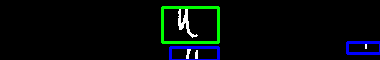

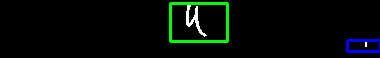

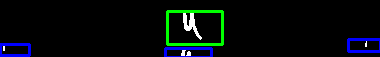

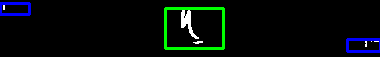

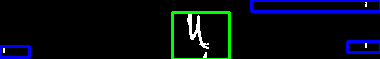

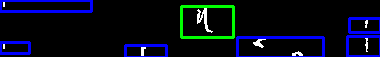

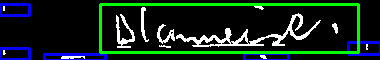

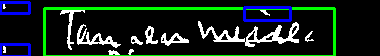

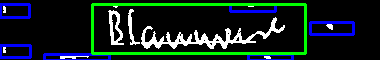

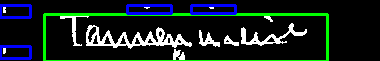

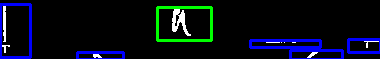

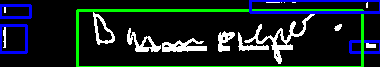

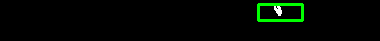

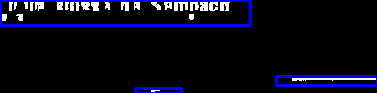

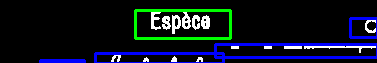

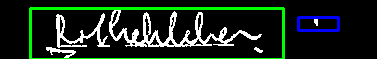

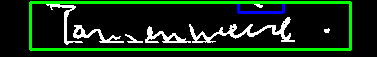

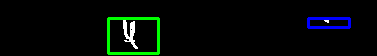

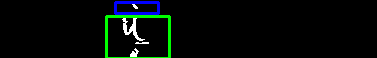

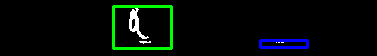

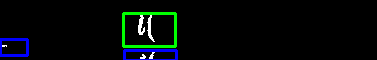

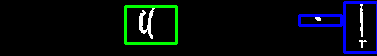

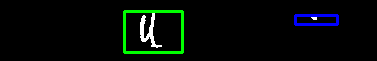

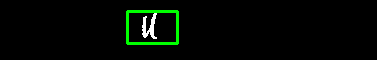

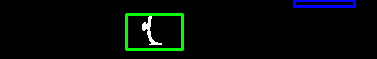

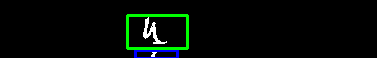

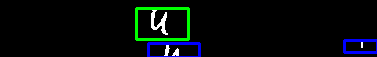

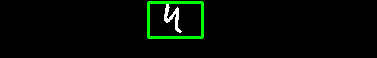

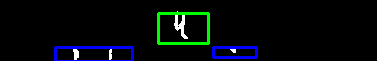

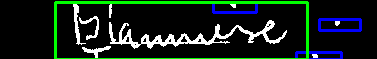

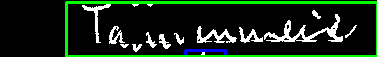

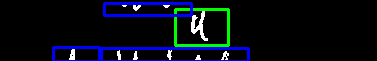

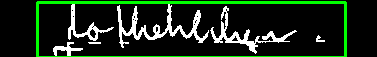

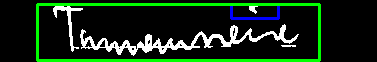

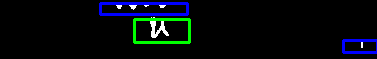

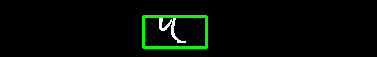

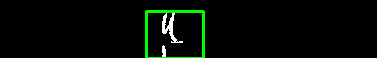

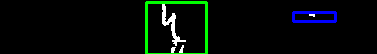

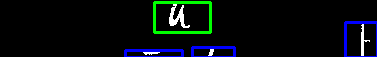

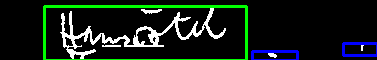

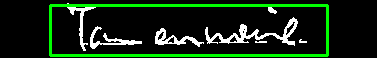

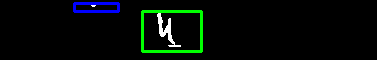

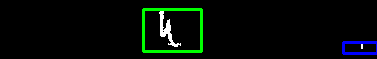

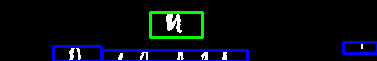

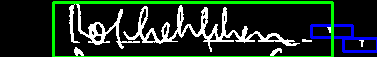

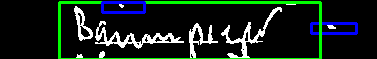

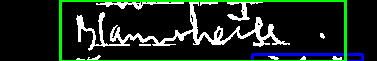

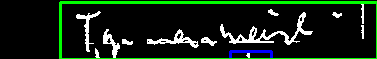

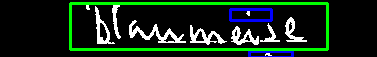

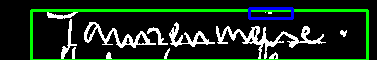

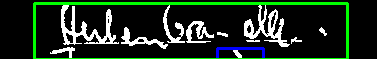

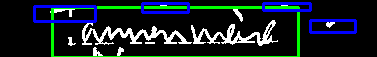

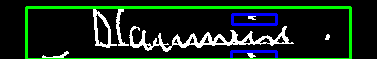

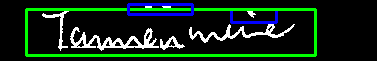

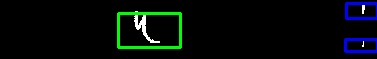

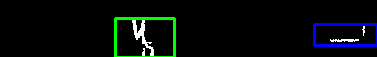

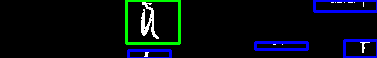

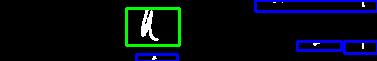

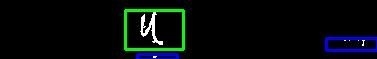

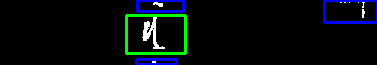

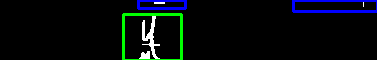

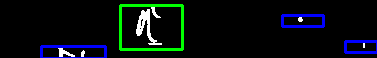

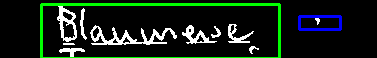

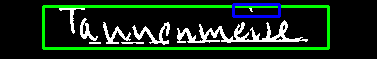

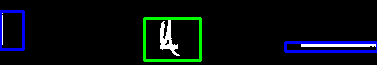

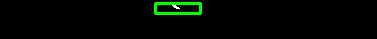

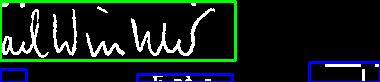

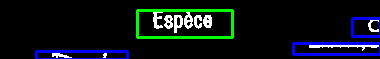

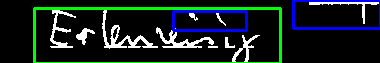

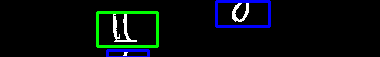

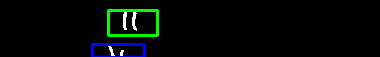

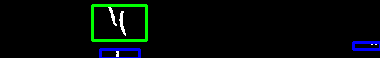

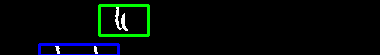

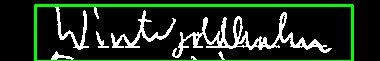

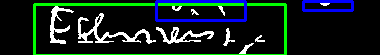

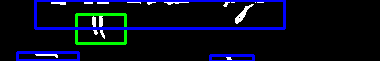

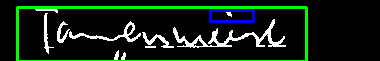

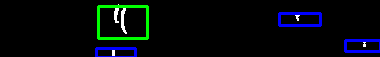

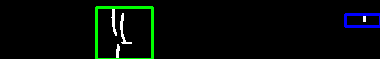

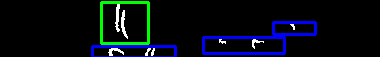

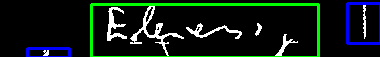

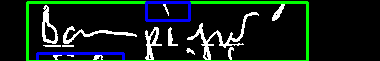

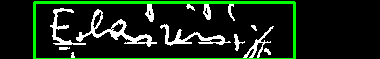

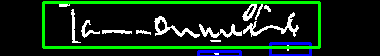

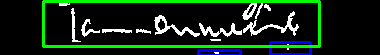

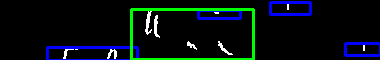

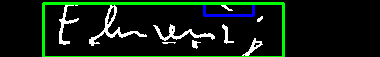

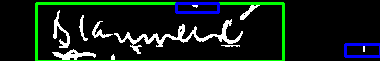

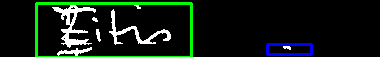

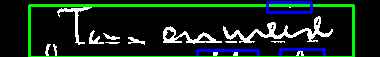

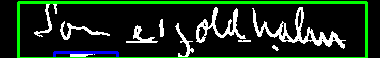

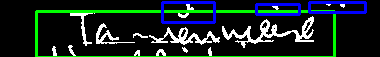

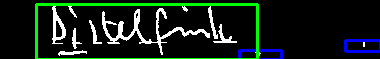

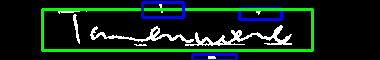

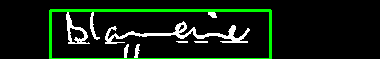

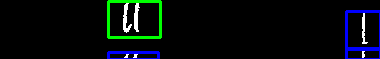

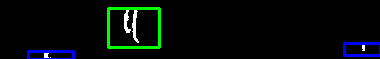

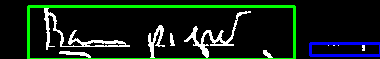

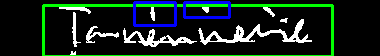

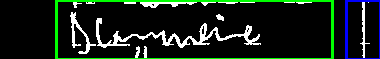

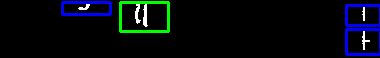

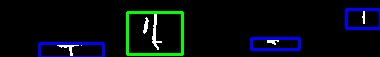

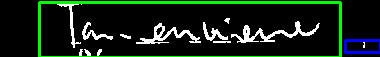

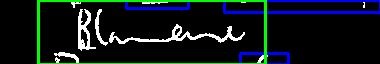

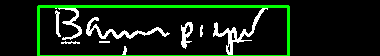

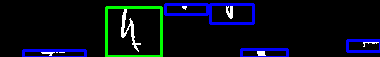

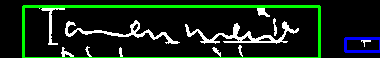

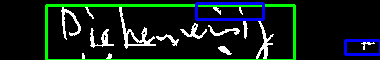

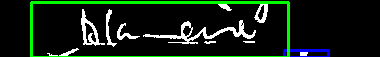

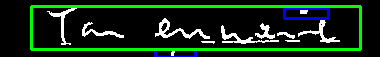

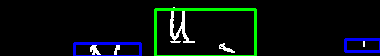

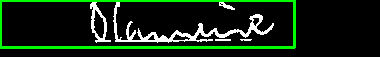

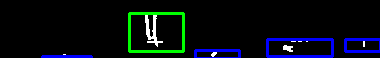

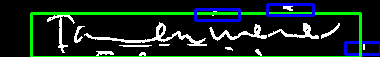

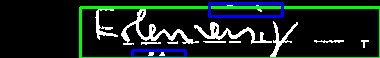

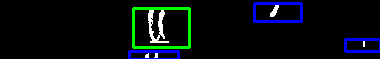

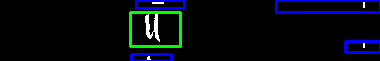

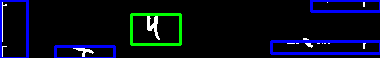

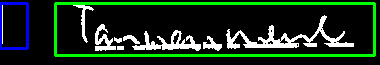

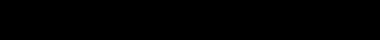

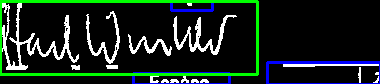

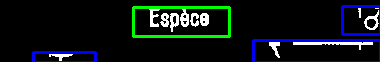

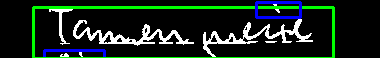

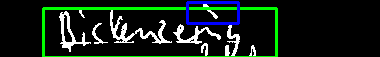

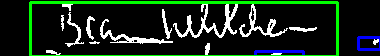

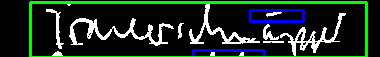

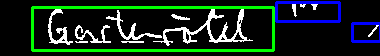

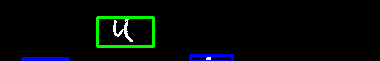

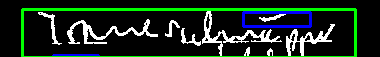

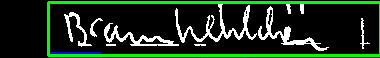

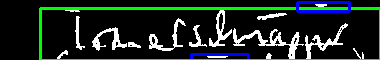

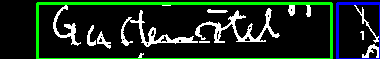

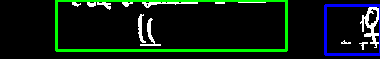

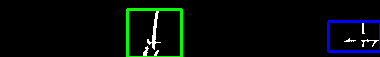

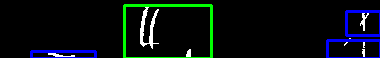

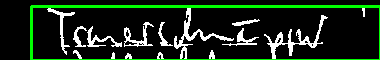

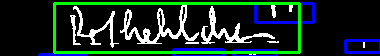

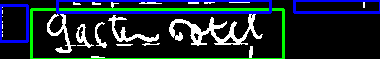

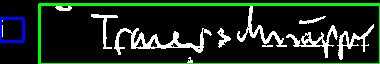

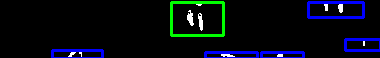

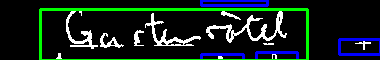

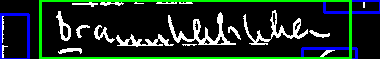

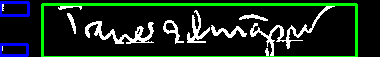

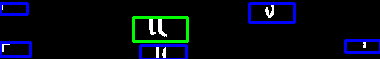

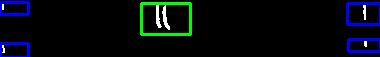

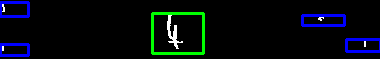

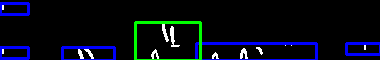

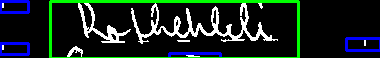

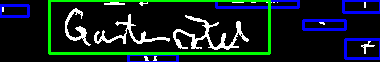

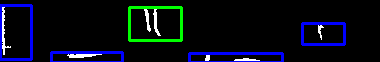

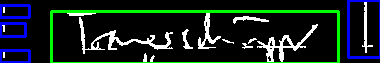

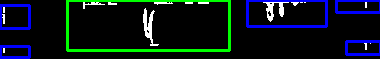

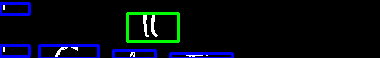

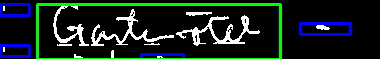

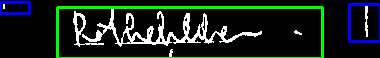

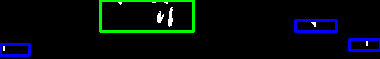

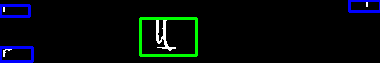

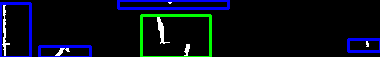

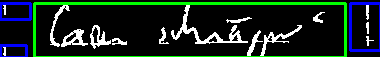

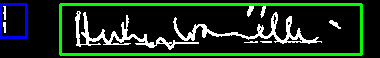

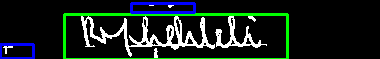

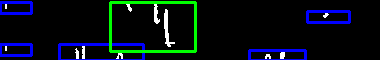

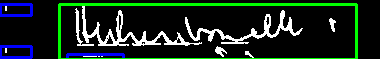

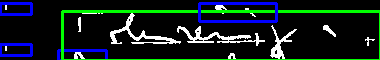

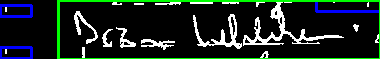

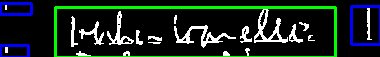

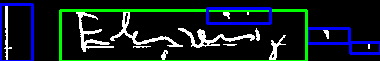

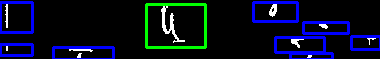

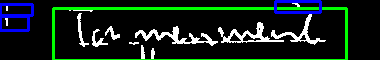

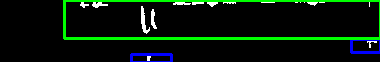

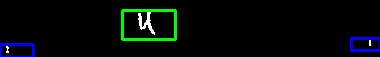

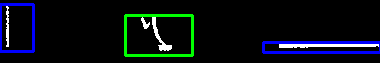

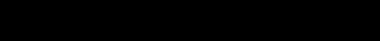

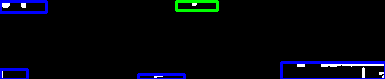

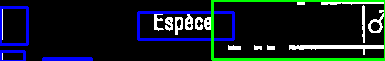

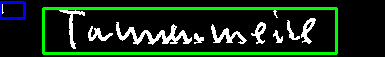

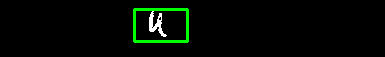

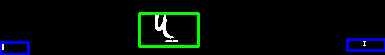

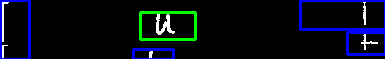

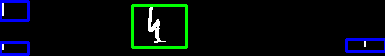

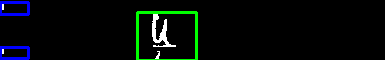

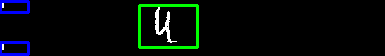

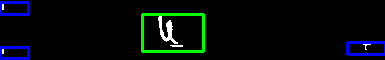

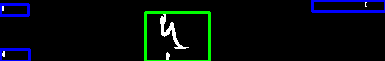

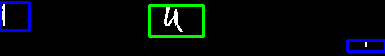

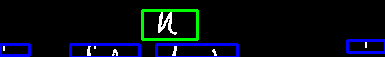

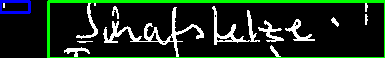

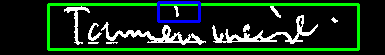

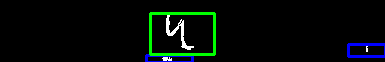

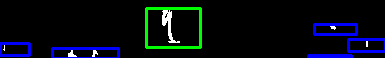

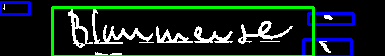

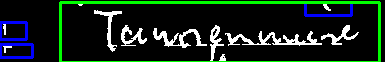

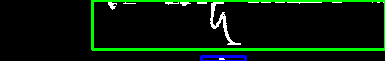

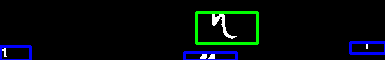

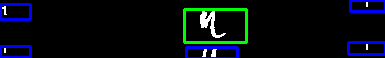

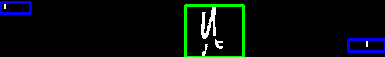

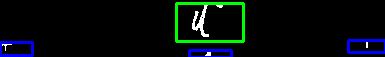

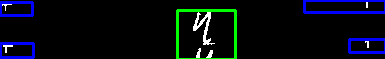

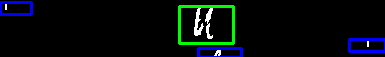

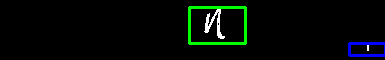

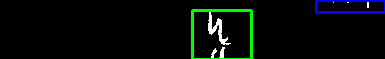

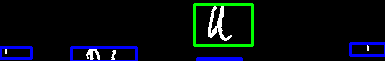

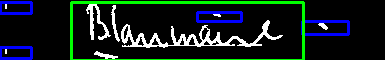

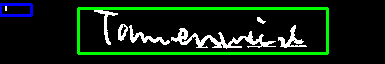

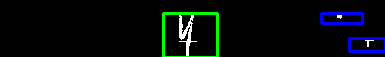

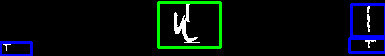

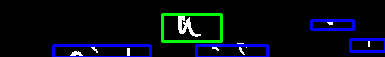

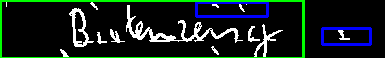

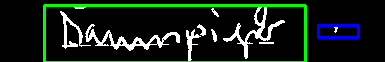

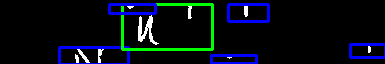

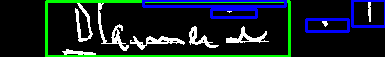

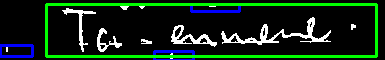

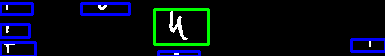

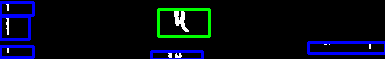

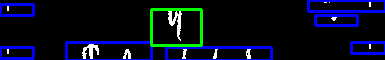

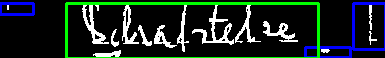

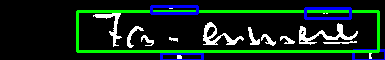

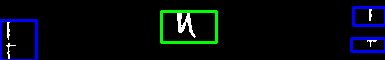

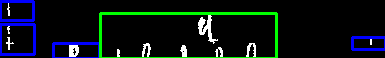

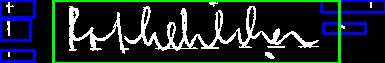

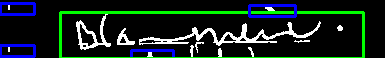

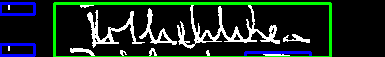

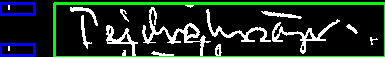

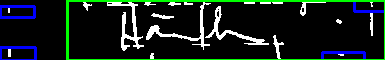

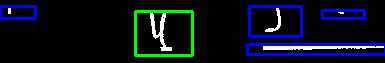

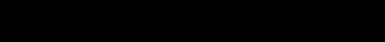

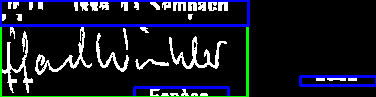

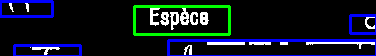

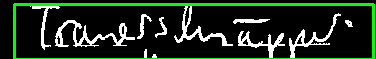

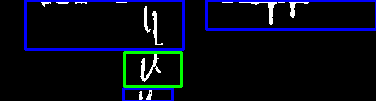

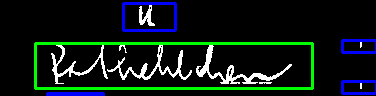

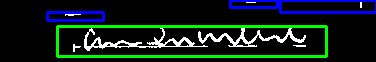

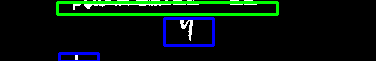

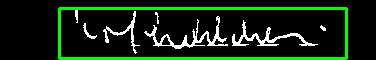

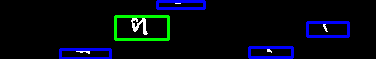

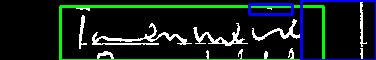

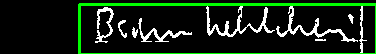

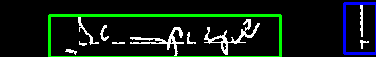

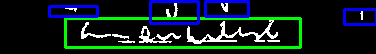

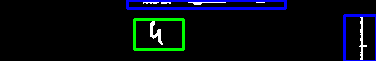

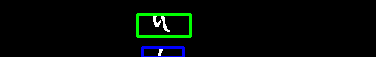

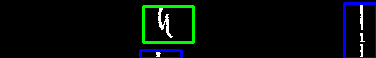

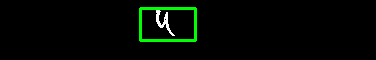

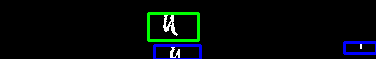

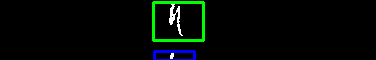

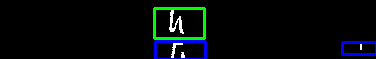

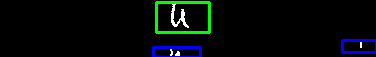

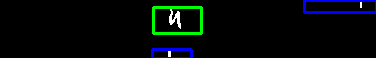

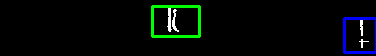

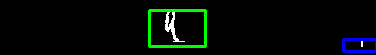

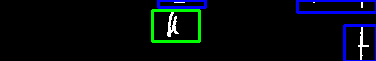

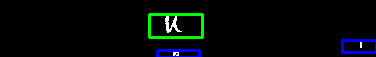

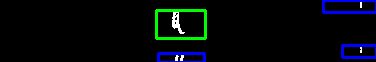

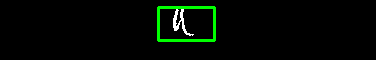

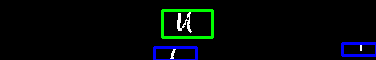

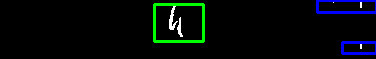

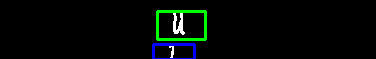

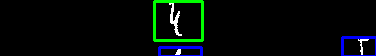

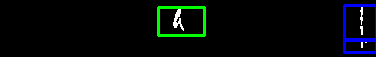

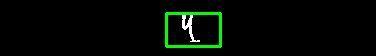

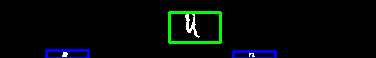

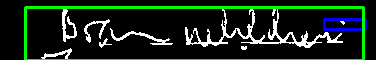

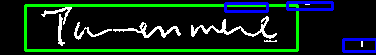

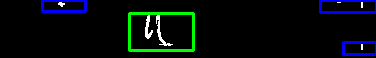

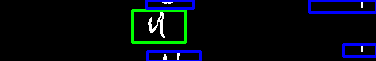

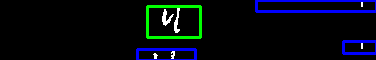

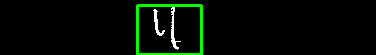

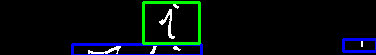

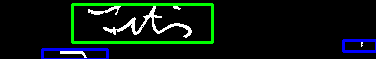

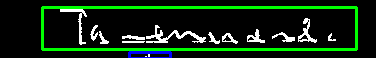

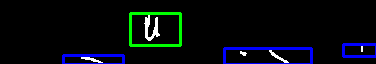

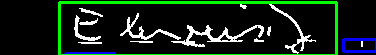

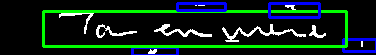

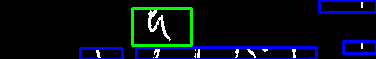

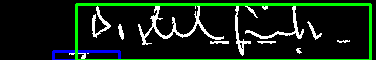

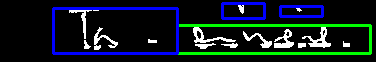

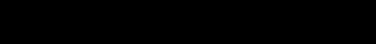

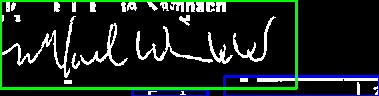

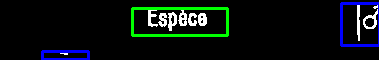

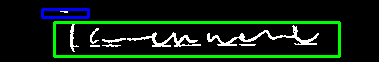

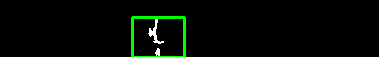

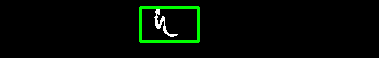

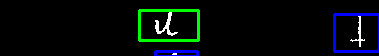

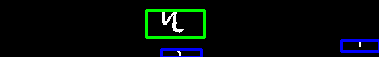

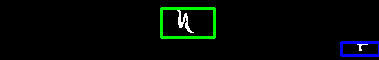

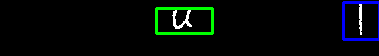

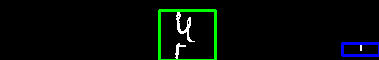

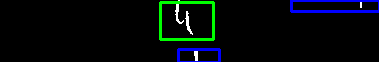

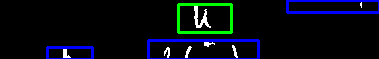

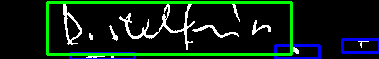

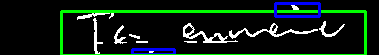

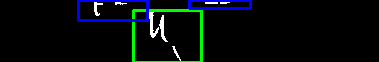

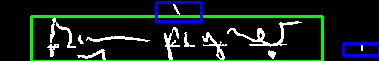

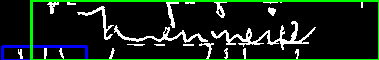

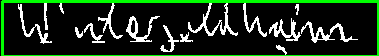

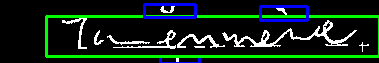

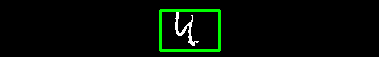

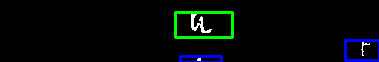

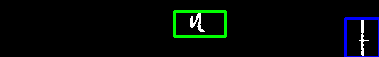

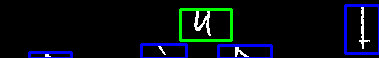

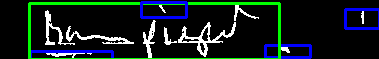

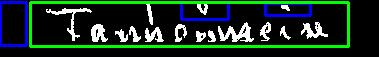

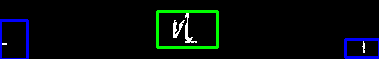

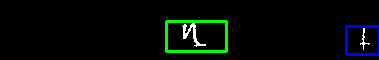

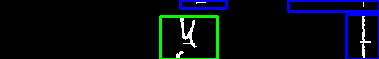

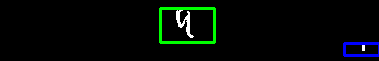

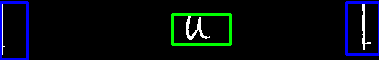

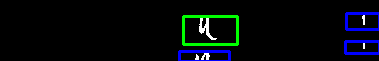

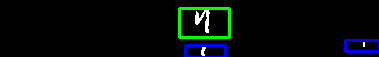

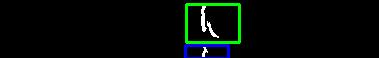

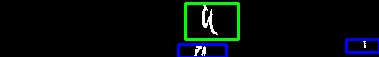

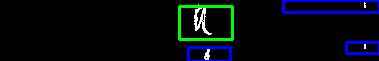

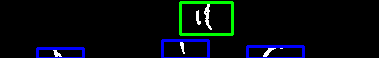

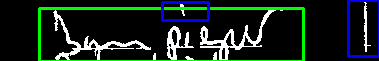

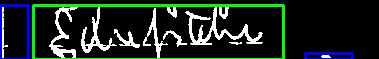

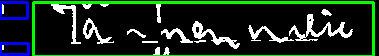

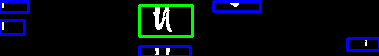

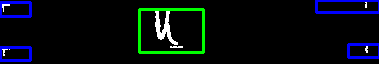

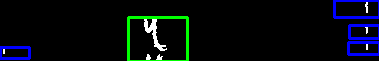

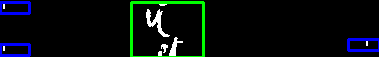

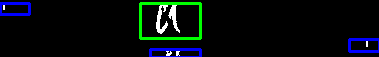

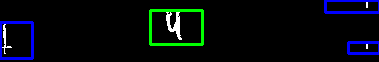

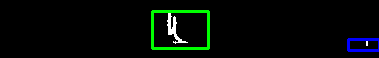

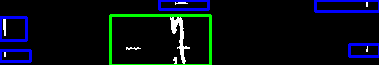

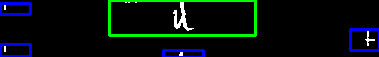

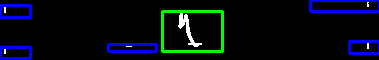

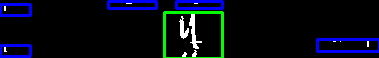

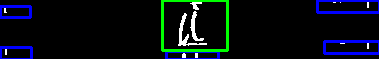

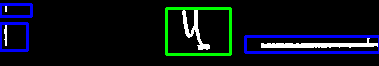

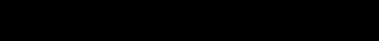

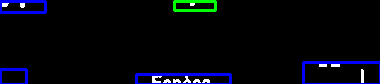

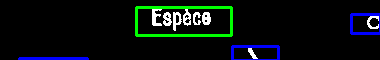

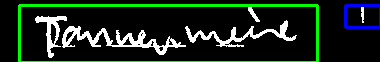

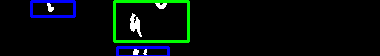

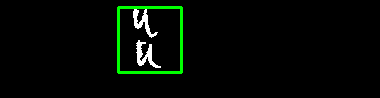

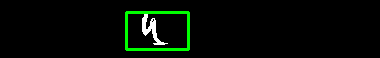

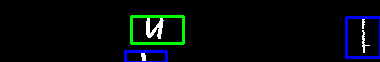

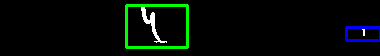

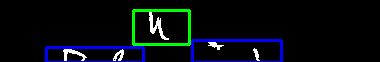

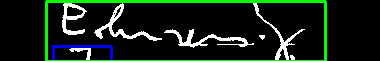

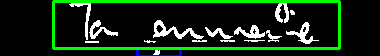

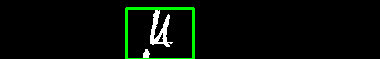

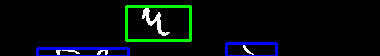

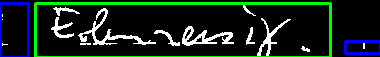

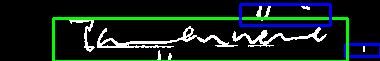

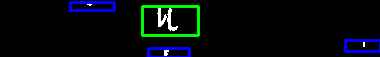

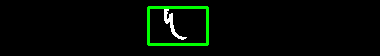

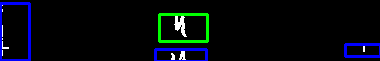

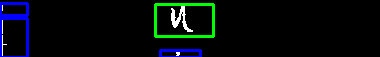

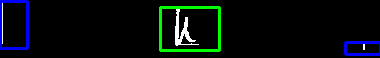

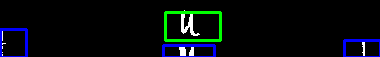

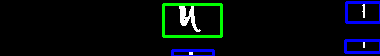

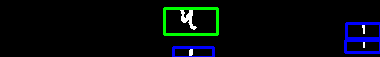

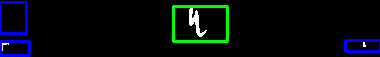

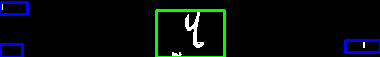

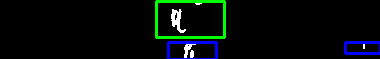

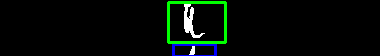

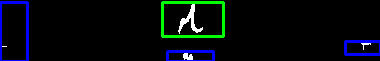

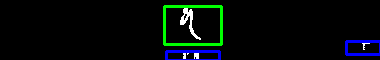

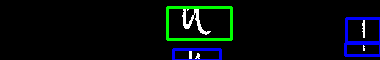

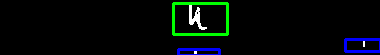

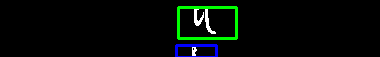

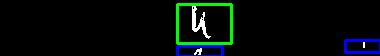

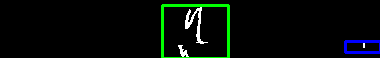

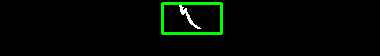

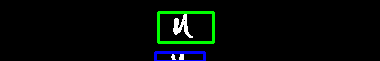

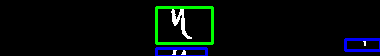

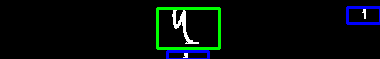

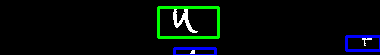

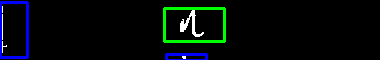

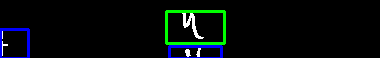

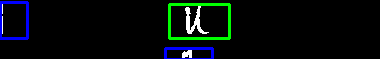

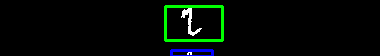

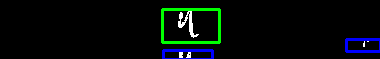

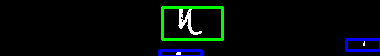

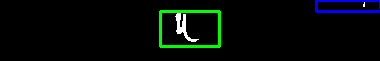

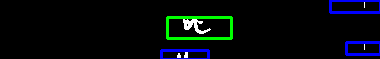

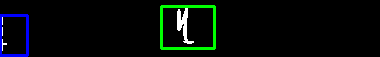

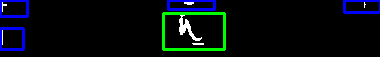

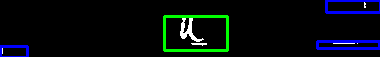

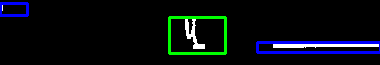

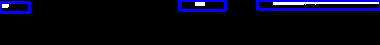

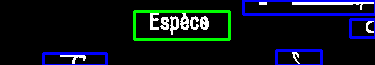

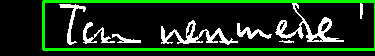

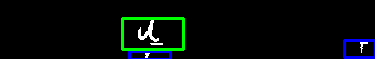

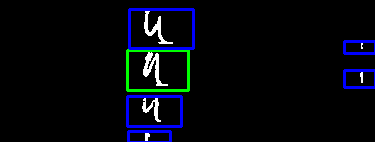

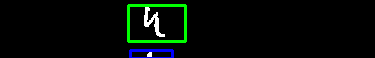

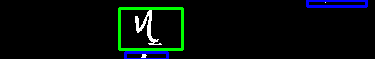

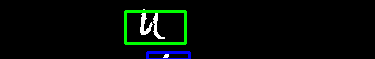

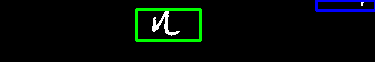

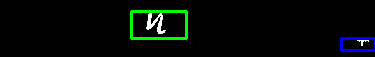

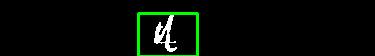

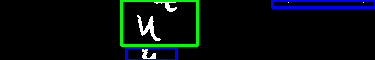

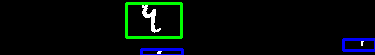

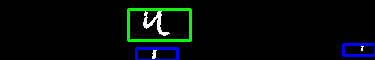

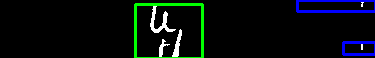

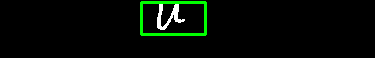

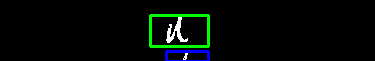

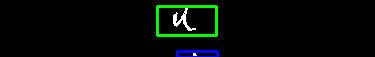

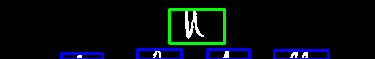

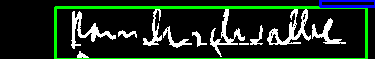

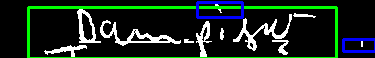

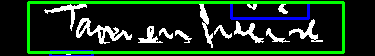

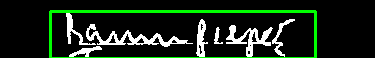

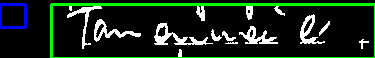

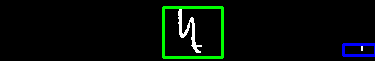

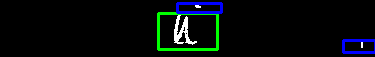

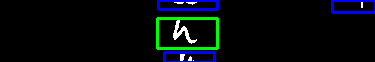

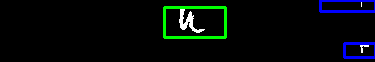

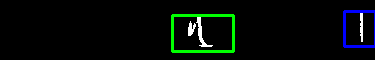

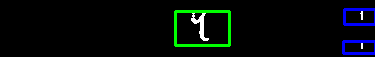

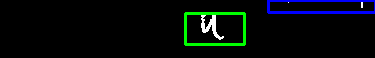

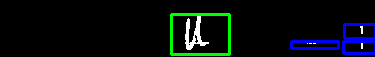

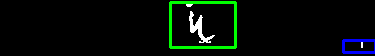

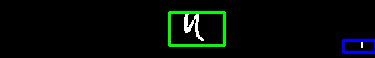

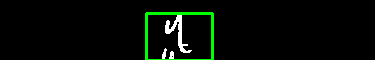

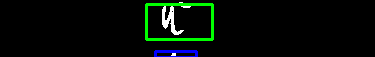

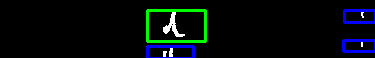

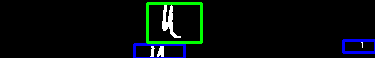

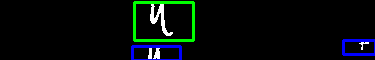

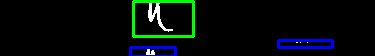

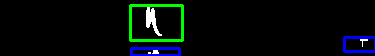

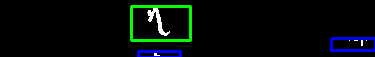

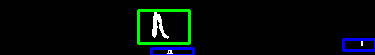

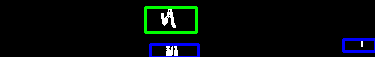

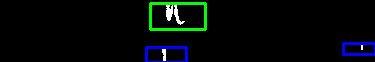

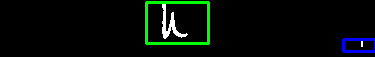

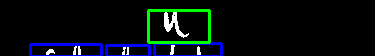

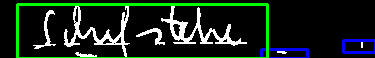

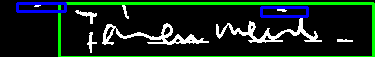

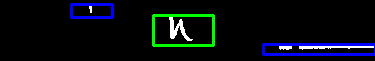

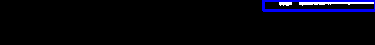

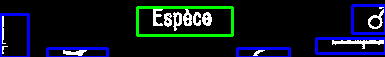

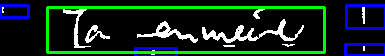

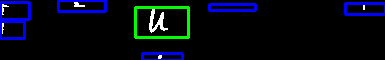

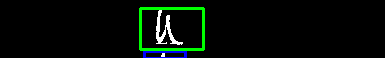

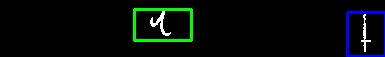

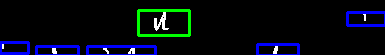

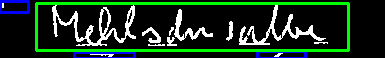

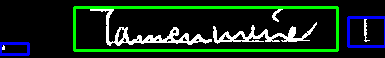

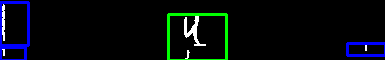

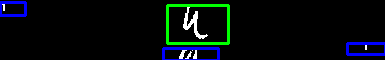

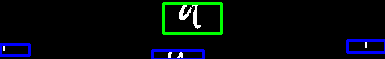

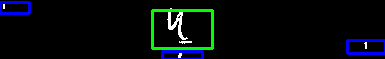

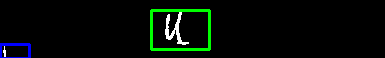

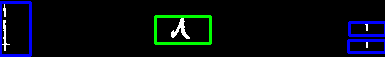

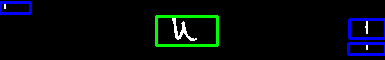

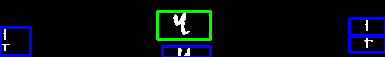

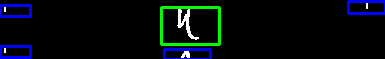

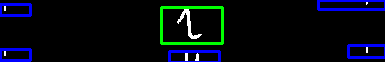

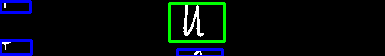

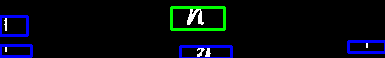

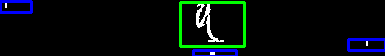

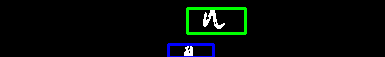

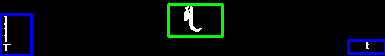

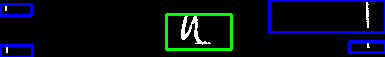

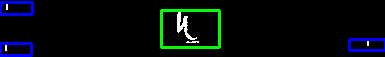

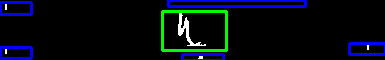

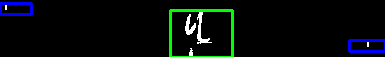

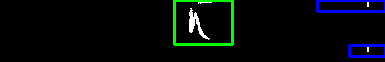

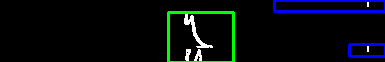

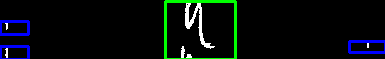

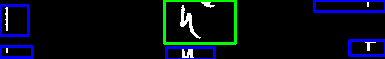

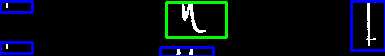

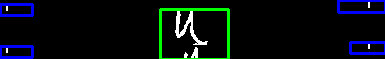

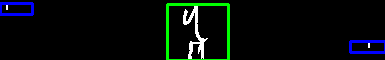

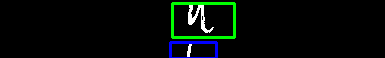

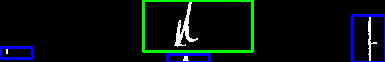

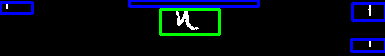

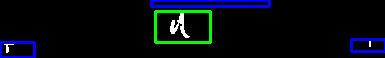

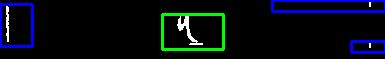

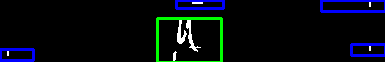

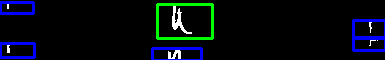

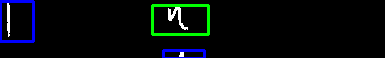

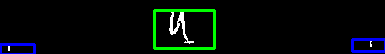

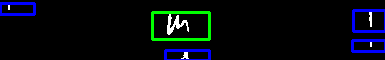

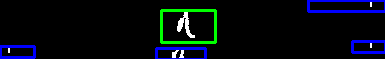

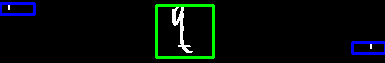

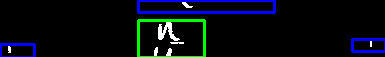

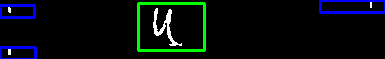

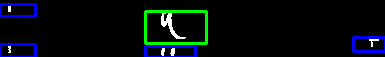

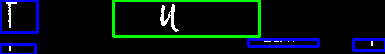

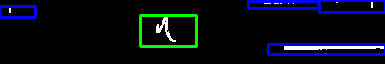

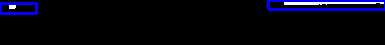

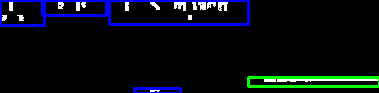

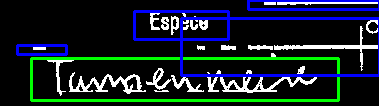

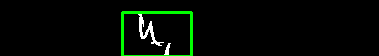

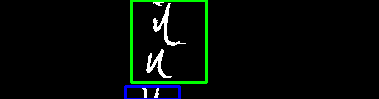

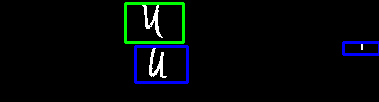

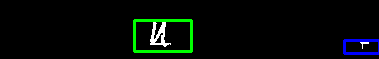

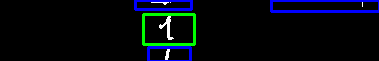

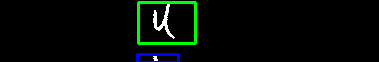

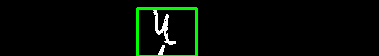

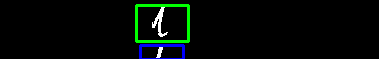

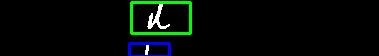

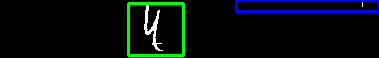

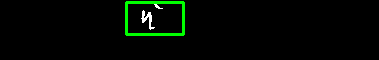

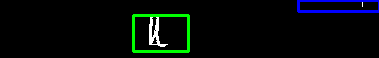

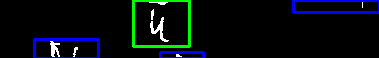

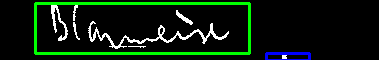

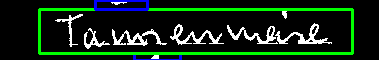

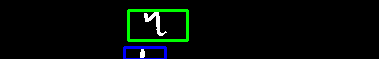

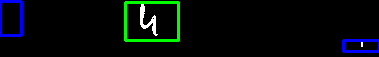

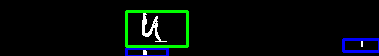

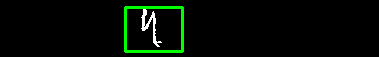

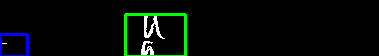

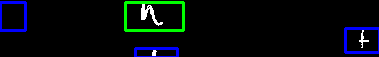

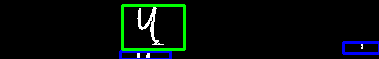

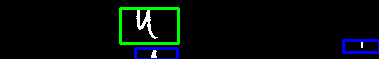

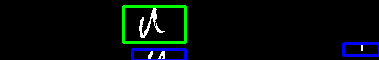

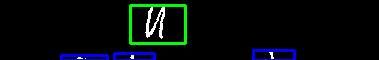

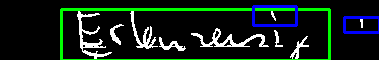

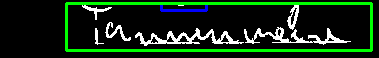

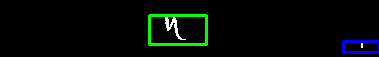

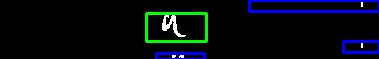

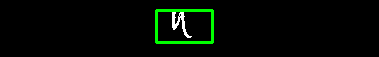

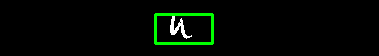

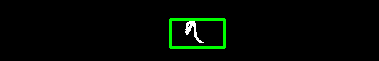

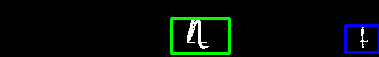

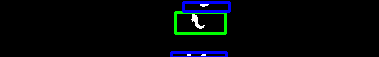

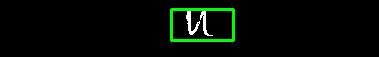

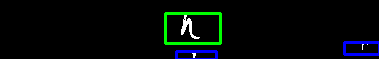

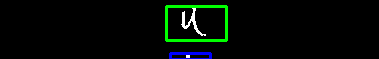

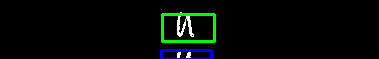

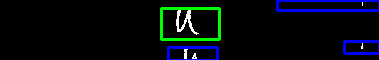

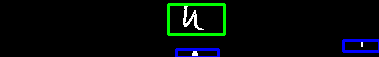

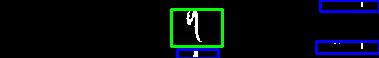

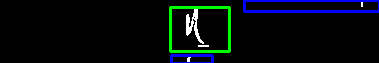

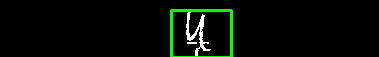

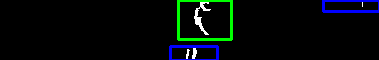

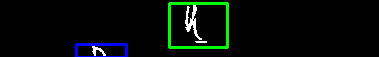

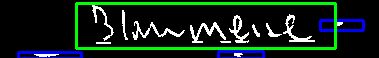

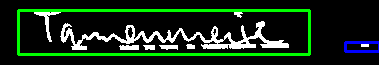

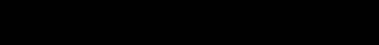

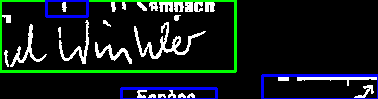

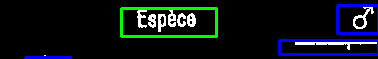

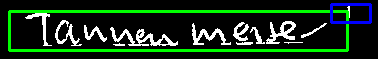

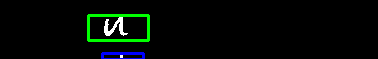

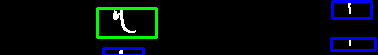

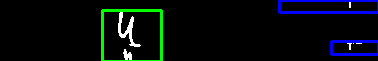

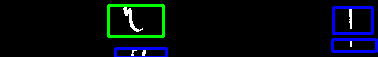

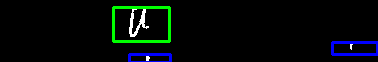

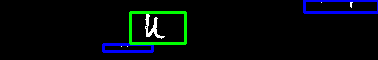

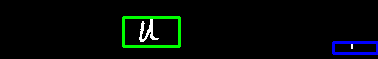

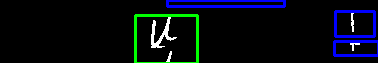

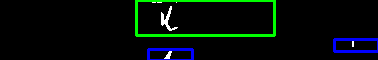

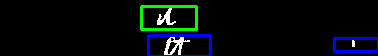

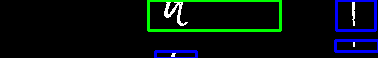

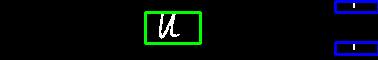

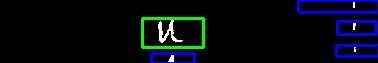

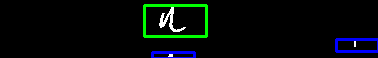

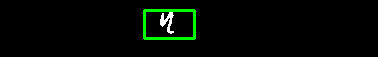

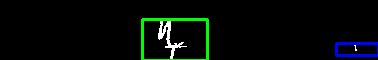

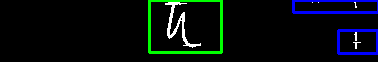

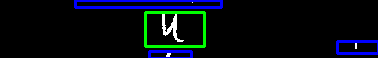

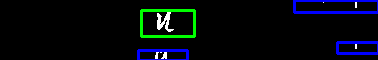

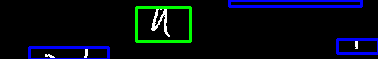

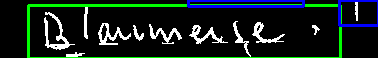

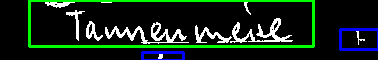

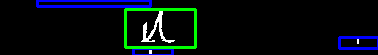

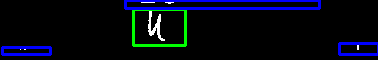

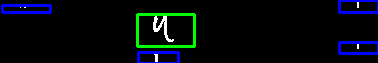

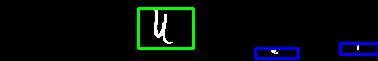

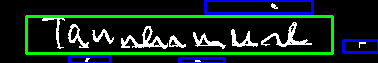

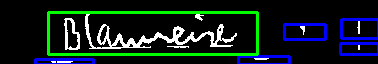

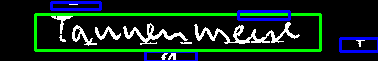

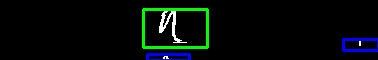

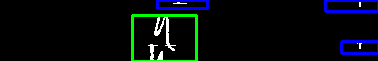

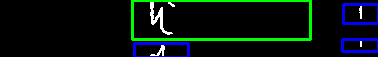

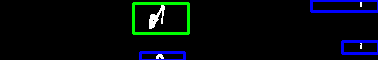

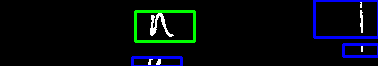

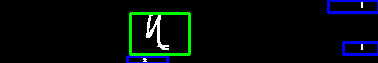

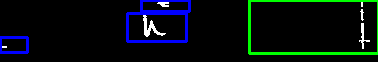

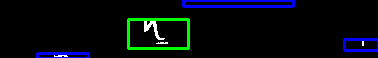

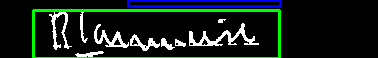

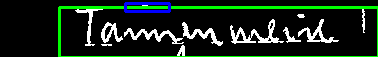

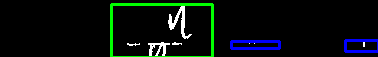

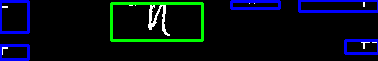

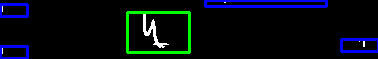

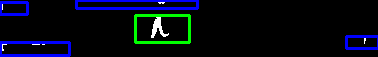

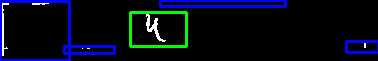

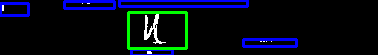

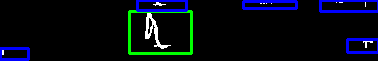

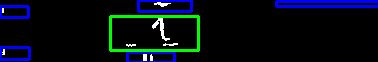

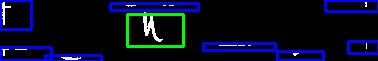

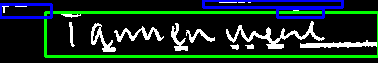

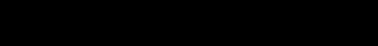

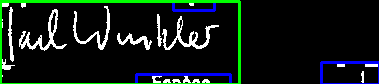

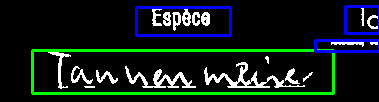

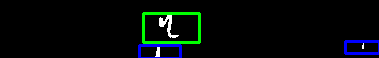

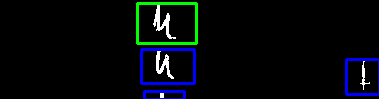

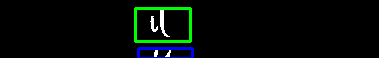

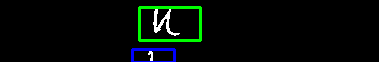

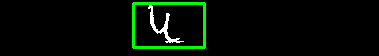

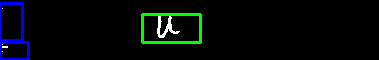

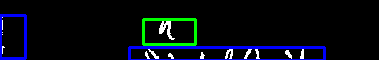

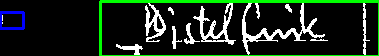

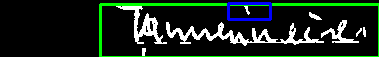

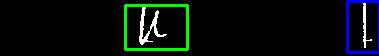

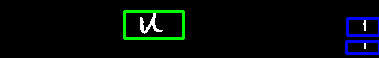

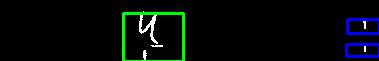

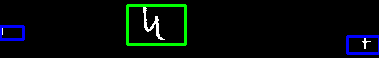

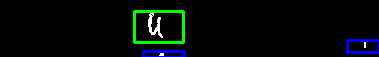

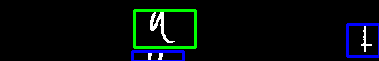

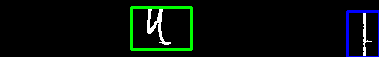

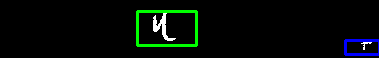

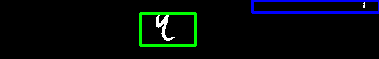

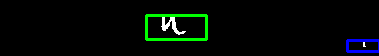

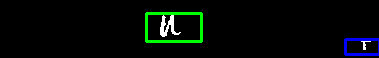

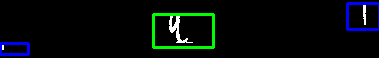

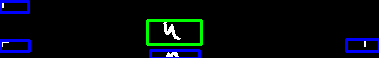

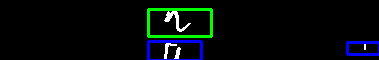

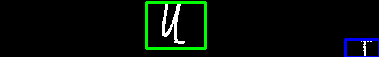

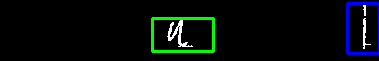

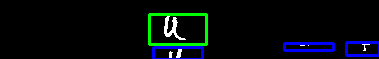

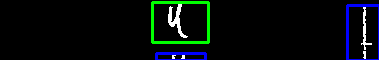

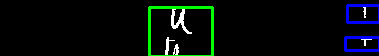

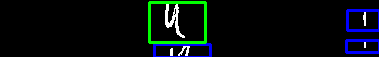

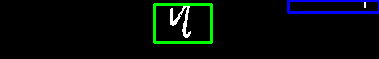

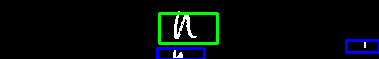

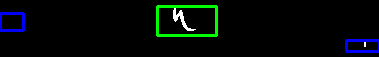

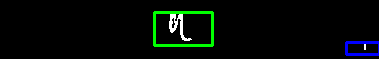

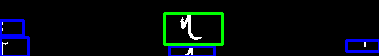

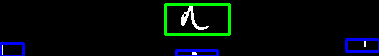

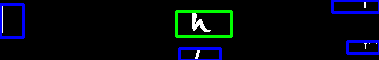

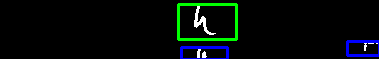

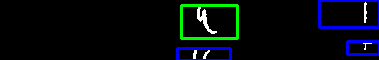

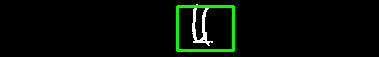

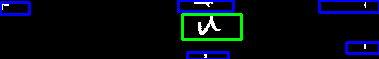

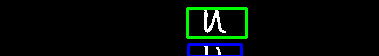

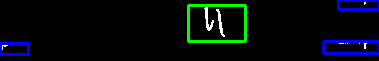

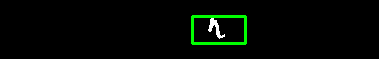

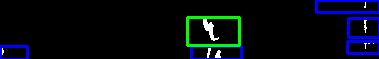

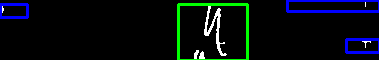

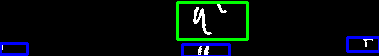

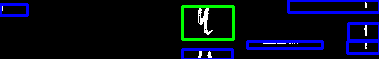

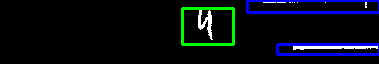

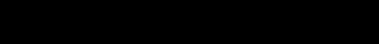

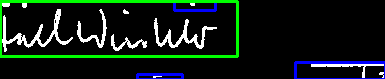

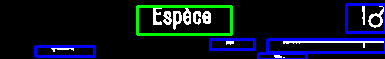

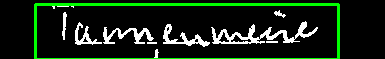

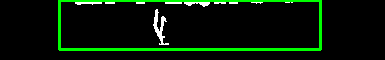

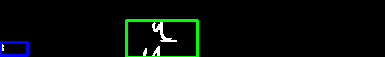

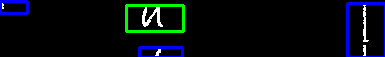

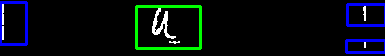

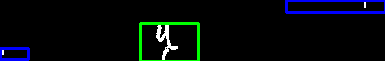

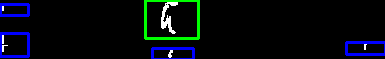

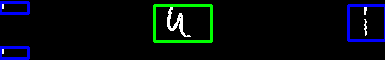

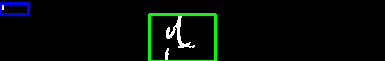

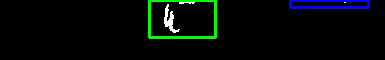

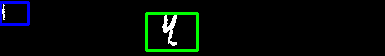

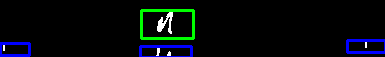

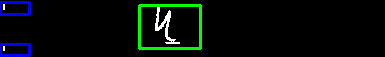

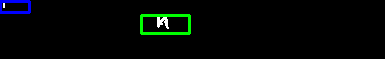

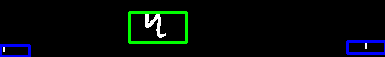

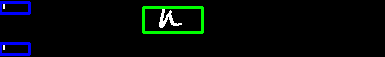

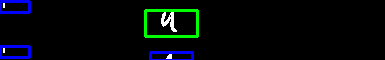

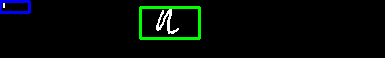

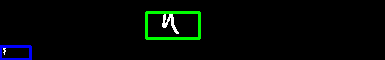

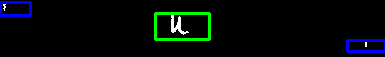

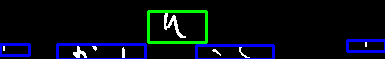

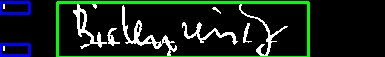

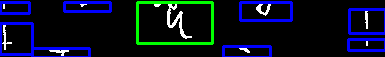

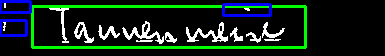

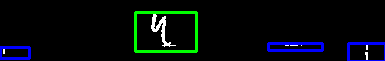

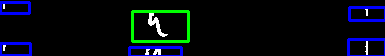

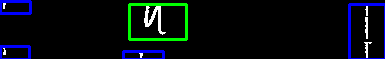

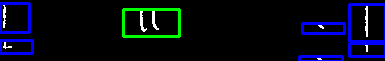

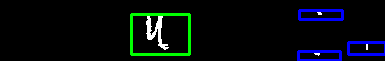

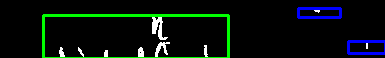

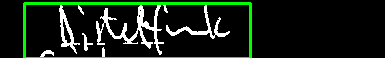

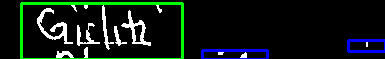

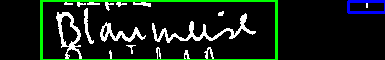

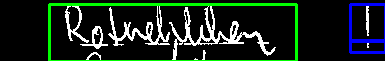

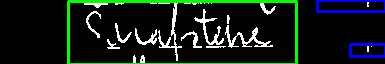

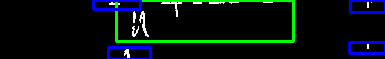

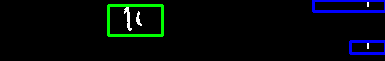

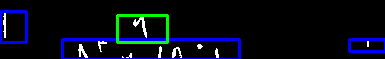

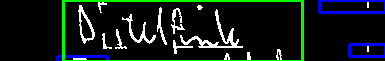

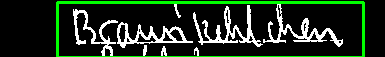

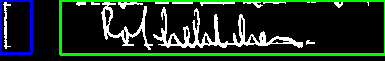

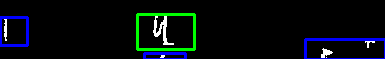

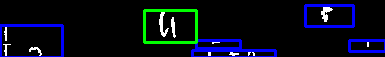

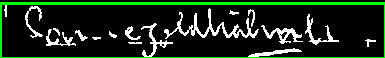

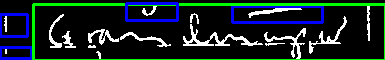

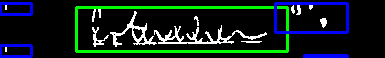

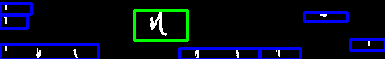

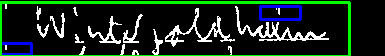

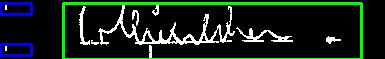

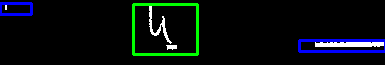

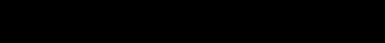

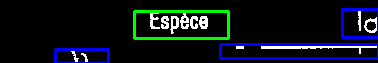

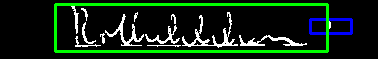

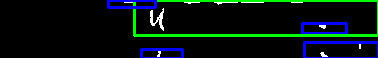

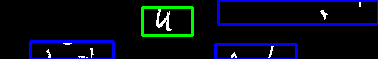

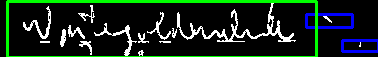

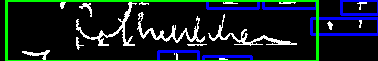

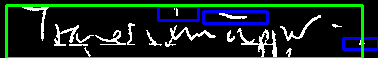

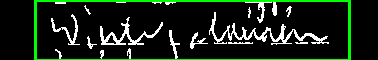

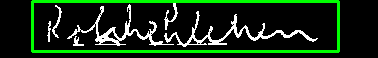

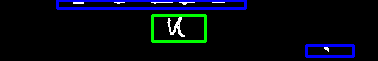

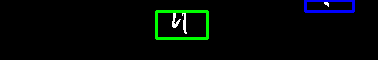

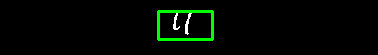

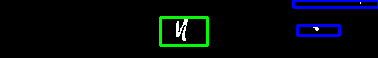

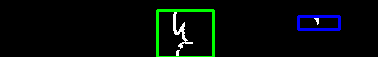

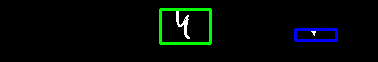

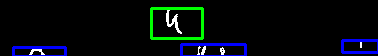

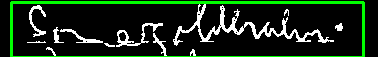

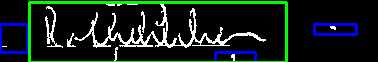

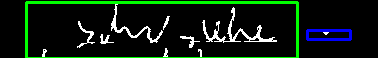

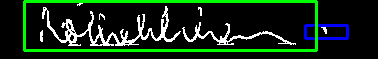

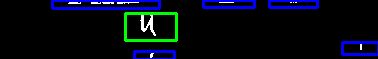

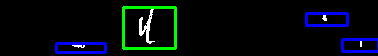

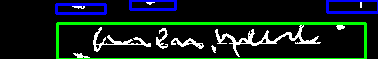

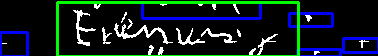

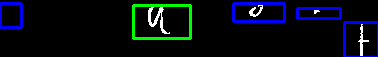

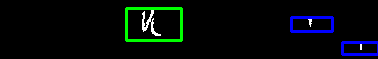

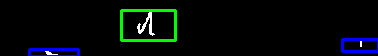

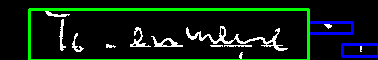

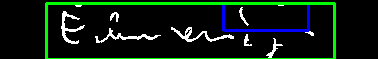

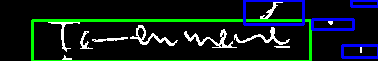

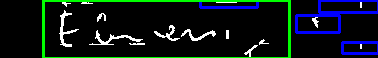

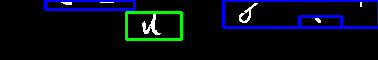

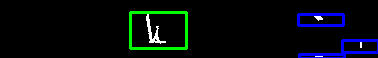

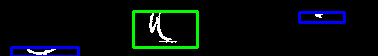

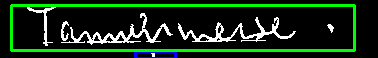

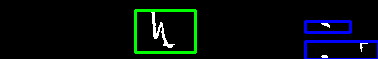

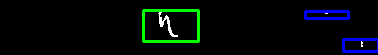

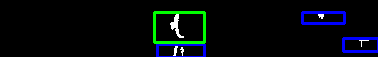

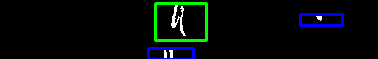

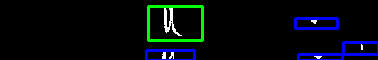

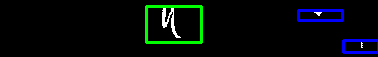

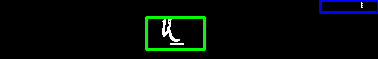

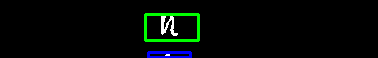

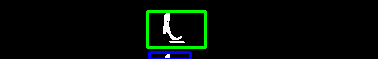

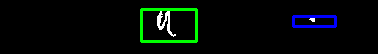

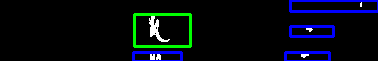

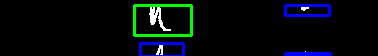

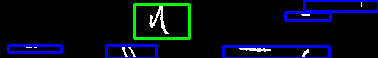

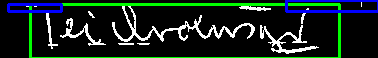

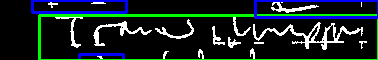

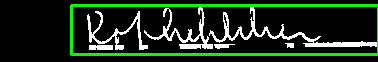

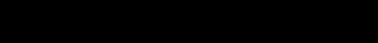

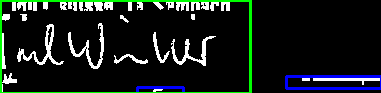

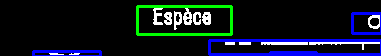

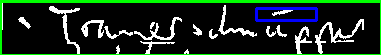

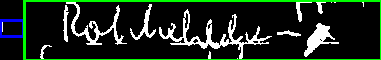

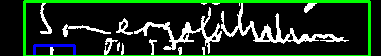

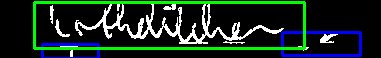

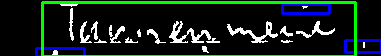

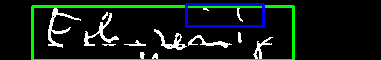

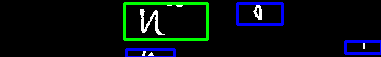

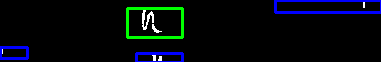

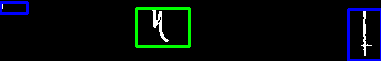

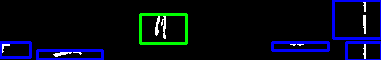

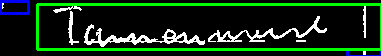

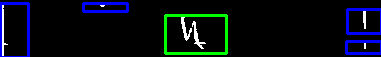

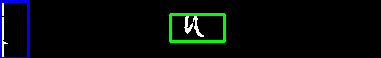

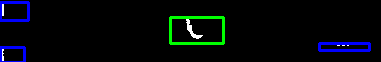

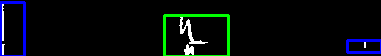

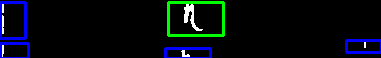

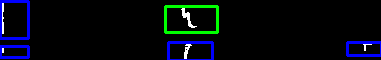

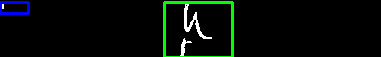

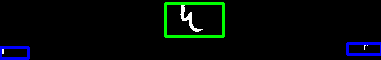

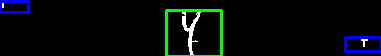

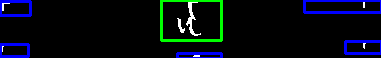

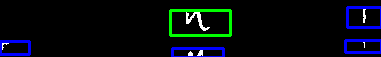

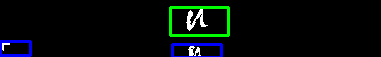

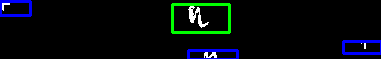

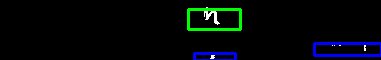

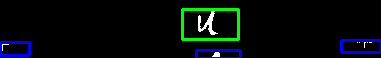

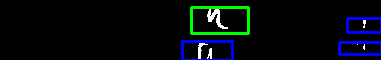

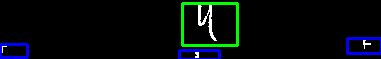

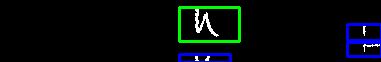

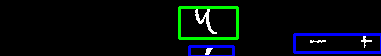

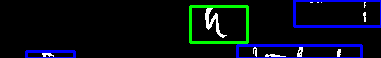

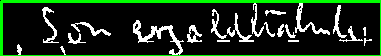

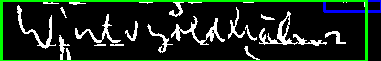

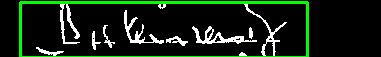

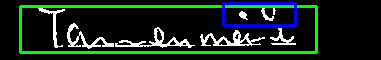

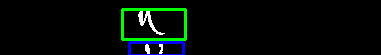

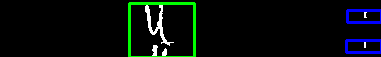

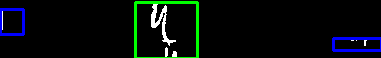

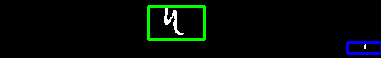

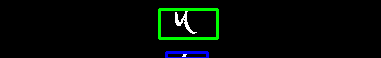

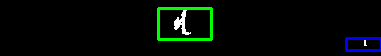

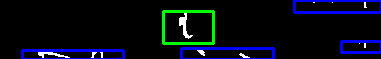

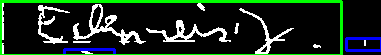

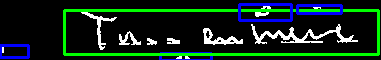

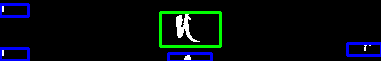

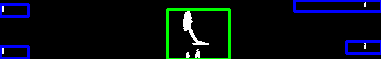

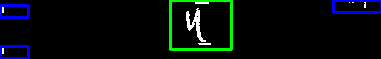

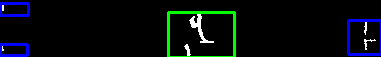

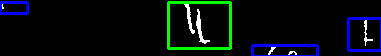

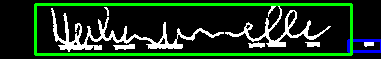

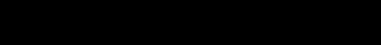

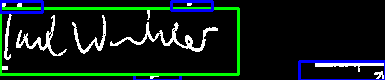

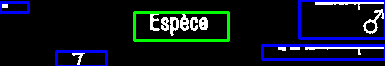

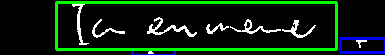

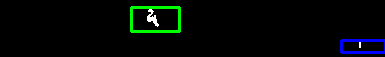

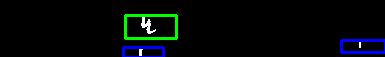

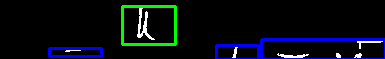

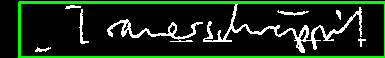

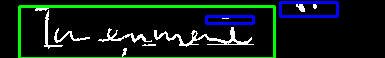

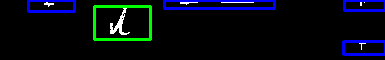

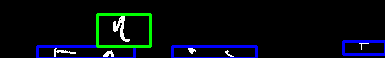

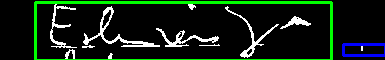

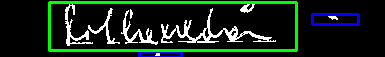

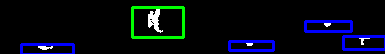

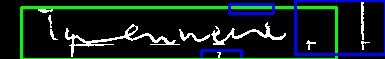

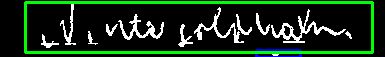

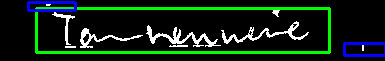

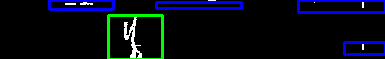

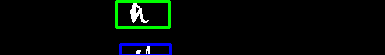

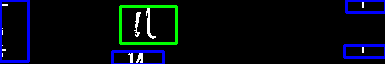

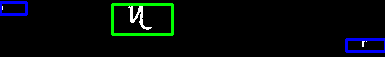

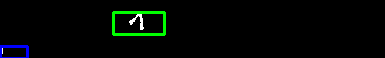

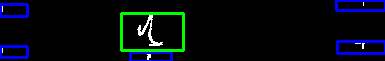

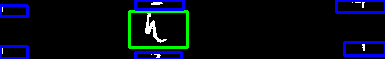

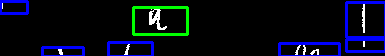

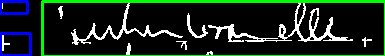

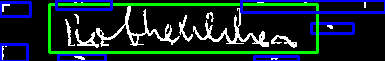

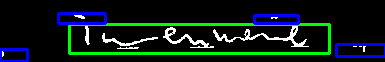

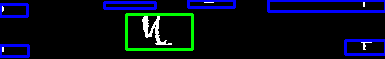

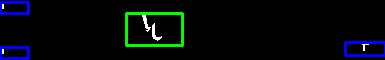

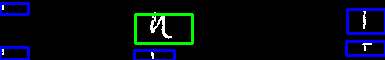

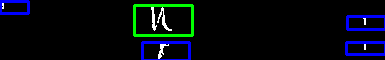

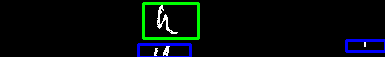

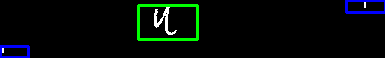

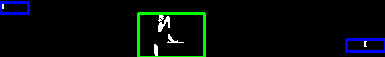

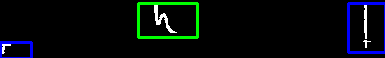

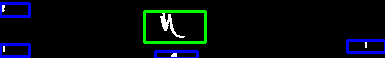

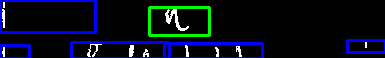

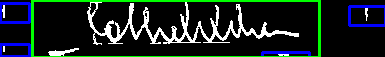

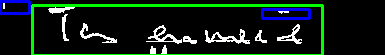

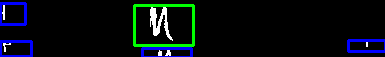

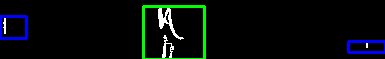

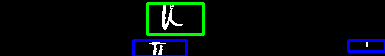

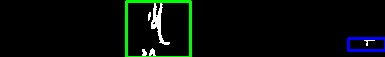

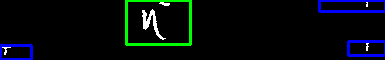

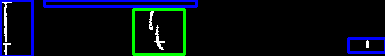

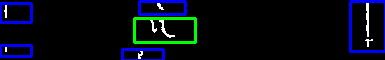

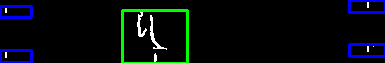

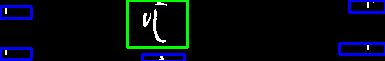

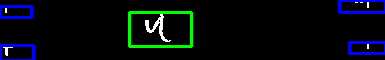

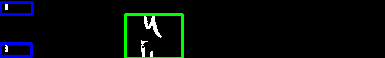

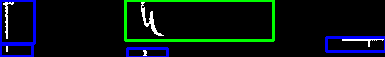

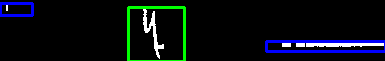

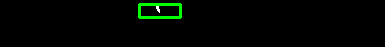

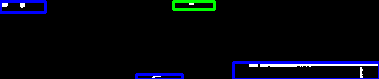

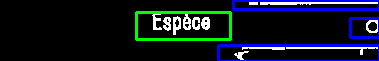

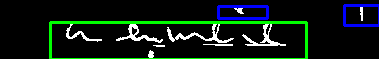

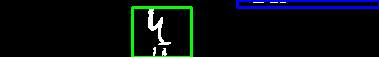

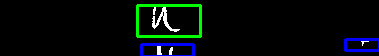

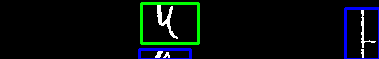

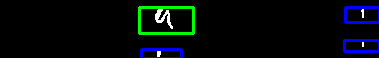

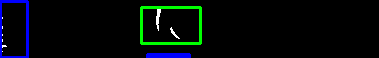

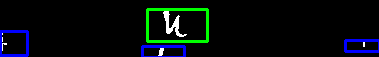

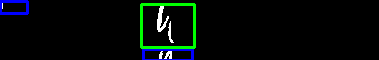

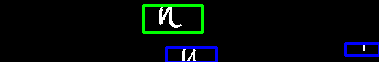

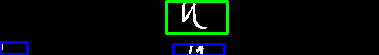

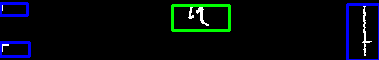

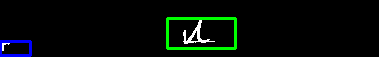

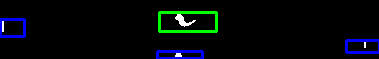

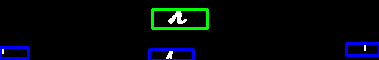

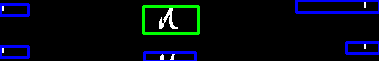

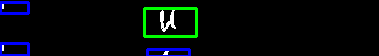

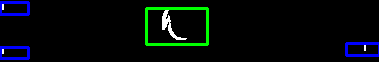

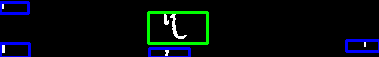

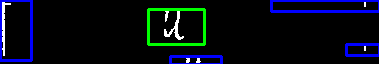

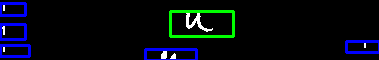

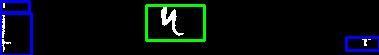

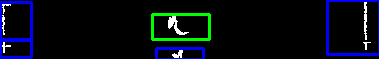

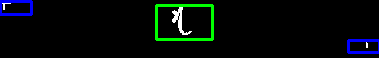

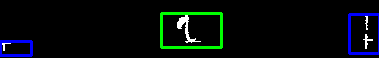

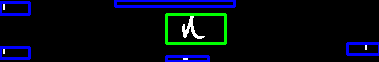

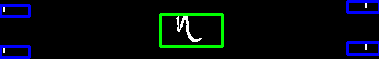

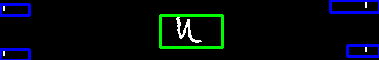

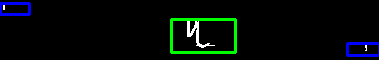

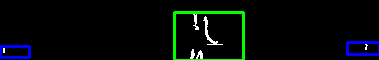

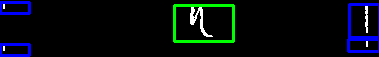

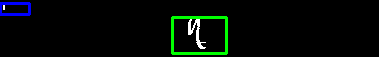

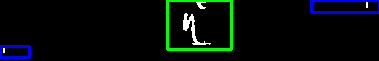

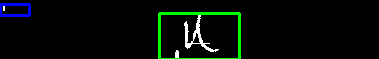

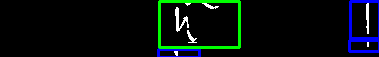

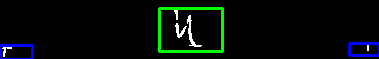

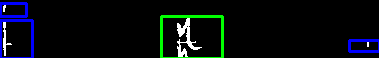

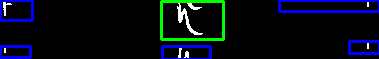

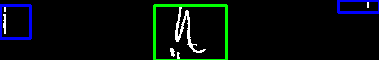

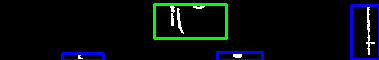

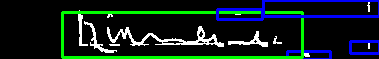

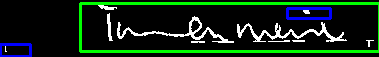

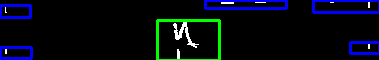

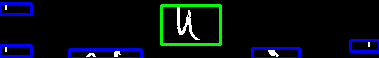

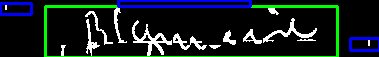

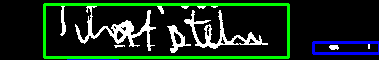

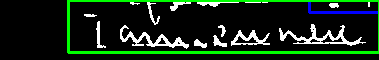

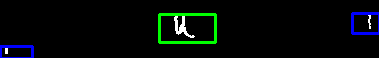

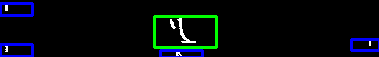

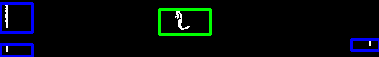

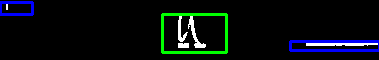

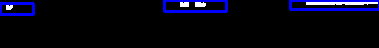

In [ ]:
species = table[0]

for pNr, page in enumerate(species):
  for rNr, row in enumerate(page):
    data = cv.bitwise_not(row)

    iHeight, iWidth = data.shape[:2]

    componentsNumber, labeledImage, componentStats, componentCentroids = cv.connectedComponentsWithStats(data, connectivity=4)
    minArea = 20
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]
    data = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

    repair_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))
    dilate = cv.dilate(data, repair_kernel, iterations=4)

    blur = cv.GaussianBlur(dilate, (33, 1), 11)
    rowCopy = np.copy(data)
    rowCopy = cv.cvtColor(rowCopy,cv.COLOR_GRAY2RGB)

    # Konturen finden
    contours, hierarchy = cv.findContours(blur, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

    contours_poly = [None] * len(contours)
    boundRect = []

    dMaxArea = 0
    foundContourIdx = -1
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv.approxPolyDP(c, 3, True)

            rect = cv.boundingRect(contours_poly[i])
            boundRect.append(rect)

            area = cv.contourArea(c)

            x, y, w, h = rect

            # Skip bounding boxes which are "definitely" borders or noise
            if (x == 0 or (x + w) == iWidth):
              if w < math.floor(iWidth / 3):
                continue

            if (y == 0 or (y + h) == iHeight):
              if h < math.floor(iHeight / 2):
                continue

            if (area > dMaxArea):
              dMaxArea = area
              foundContourIdx = len(boundRect) - 1



    # Draw the bounding boxes on the (copied) input image:
    for i in range(len(boundRect)):
      color = (255, 0, 0) # Blue bounding boxes can be removed

      if i == foundContourIdx:
        color = (0, 255, 0) # Green stays

      cv.rectangle(rowCopy, (int(boundRect[i][0]), int(boundRect[i][1])), (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)
    cv2_imshow(rowCopy)